In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
data = tf.keras.datasets.mnist.load_data()

(x_train, y_train), (x_test, y_test) = data

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
def show_image(i):
  print(y_train[i])
  plt.imshow(x_train[i], cmap='gray')

## Normalization

In [ ]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_train.shape

(60000, 28, 28, 1)

In [ ]:
min_val, max_val = x_train.min(), x_train.max()
min_val, max_val

(0, 255)

In [ ]:
k = (max_val - min_val) / 2;
x_train = (x_train - k) / k

min_val, max_val = x_train.min(), x_train.max()
min_val, max_val

(-1.0, 1.0)

In [ ]:
batch_size = 256
buffer_size = 60000

x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

## Building the model

In [ ]:
def build_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(units = 7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape(target_shape=(7, 7, 256)))

    model.add(layers.Conv2DTranspose(filters=256, kernel_size=5, strides=(2,2), padding="same", use_bias=False)) # 7x7x256
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2,2), padding="same", use_bias=False)) # 14x14x256
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filters=1, kernel_size=5, padding="same", use_bias=False, activation='tanh')) # 28x28x1

    model.summary()

    return model


In [ ]:
generator = build_generator()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_9 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 256)       1638400   
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 14, 14, 256)      

In [ ]:
random_noise = tf.random.normal([1, 100])
random_noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.3759413 , -1.4764527 , -1.0040929 ,  0.44317666, -0.71549183,
        -0.2796313 ,  1.3008012 , -0.8103875 , -0.1121842 ,  0.07091997,
        -0.07920378, -0.652344  ,  0.03815313,  0.33130214, -1.3445411 ,
        -0.9819815 , -0.68222386, -1.1169156 , -0.4155336 ,  0.7695998 ,
        -1.0975162 ,  1.0072492 , -1.2718757 ,  0.12114747,  0.41561583,
        -0.77435225, -0.59396994, -0.3900816 ,  0.15618174, -1.3348726 ,
         1.5676053 ,  1.128526  ,  0.5857775 , -1.2736712 , -0.25786647,
         0.18601394, -1.3572202 ,  0.7299027 ,  0.60988826,  0.47110412,
         1.6653506 , -0.8022177 ,  0.67839193, -1.2478132 ,  0.05397307,
        -0.03440978, -1.5454018 ,  0.08891045, -0.15736504, -0.17778347,
        -0.38635004,  1.1063619 , -0.8656423 ,  0.33533567,  0.6338209 ,
        -1.0795994 ,  0.9058617 ,  0.680177  ,  0.8209924 ,  1.5474026 ,
        -0.77197546, -0.32463017, -0.89986944,  0.5100708 ,  0.6318067 ,
 

In [ ]:
generated_image = generator(random_noise, training=False)

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

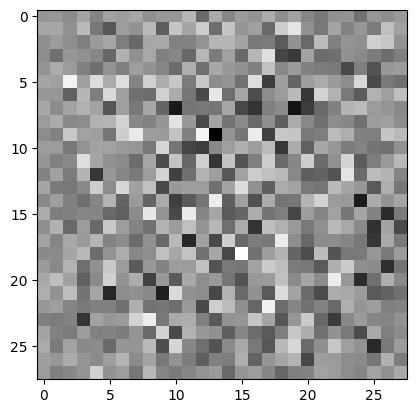

In [ ]:
plt.imshow(generated_image[0], cmap="gray")

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
discriminator = build_discriminator()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

In [ ]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [ ]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  #print(noise.shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [ ]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Epoch:  1


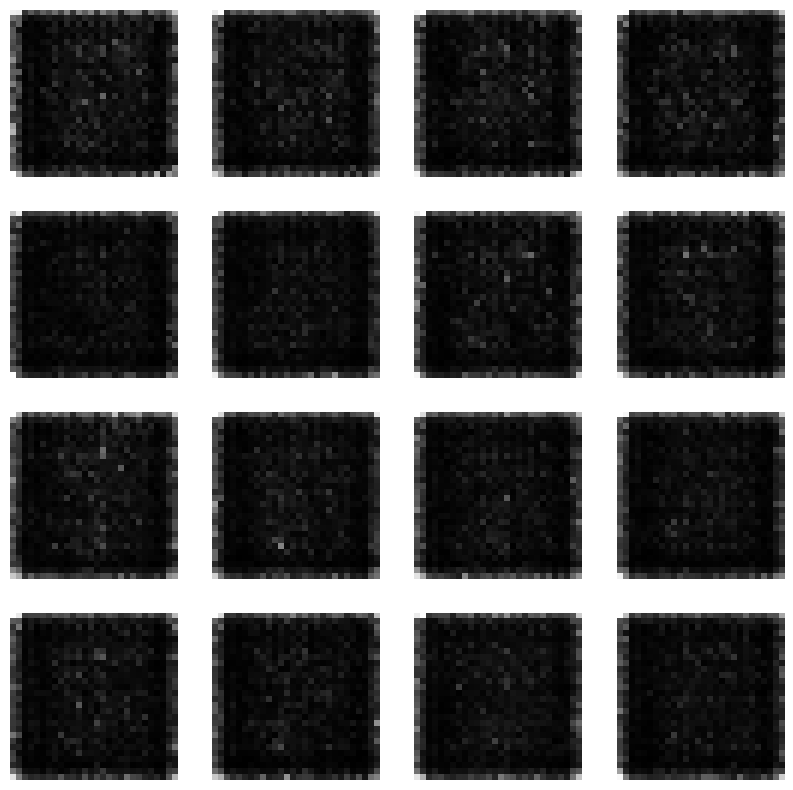

Epoch:  2


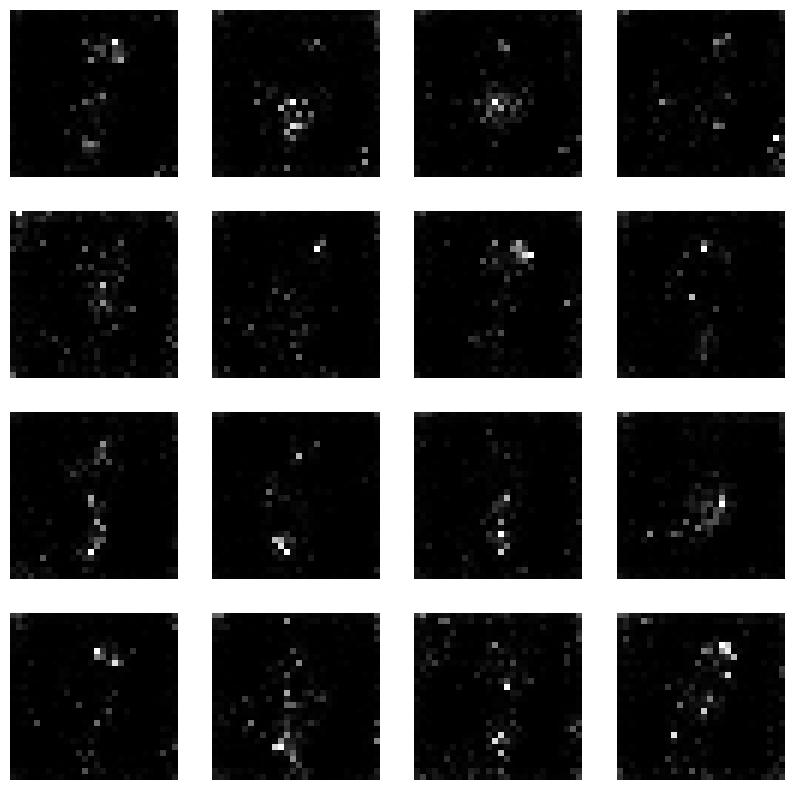

Epoch:  3


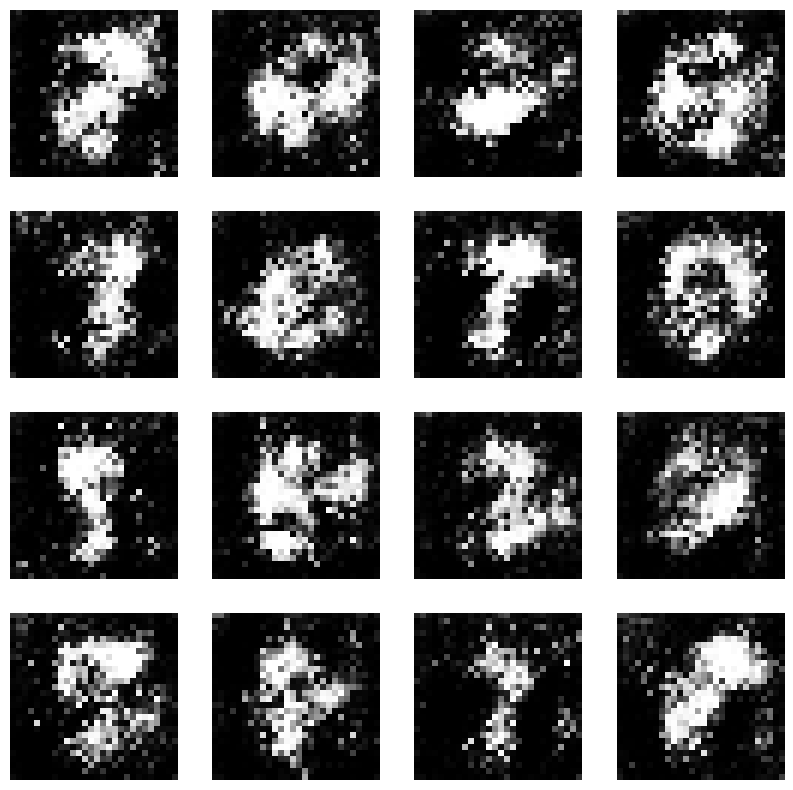

Epoch:  4


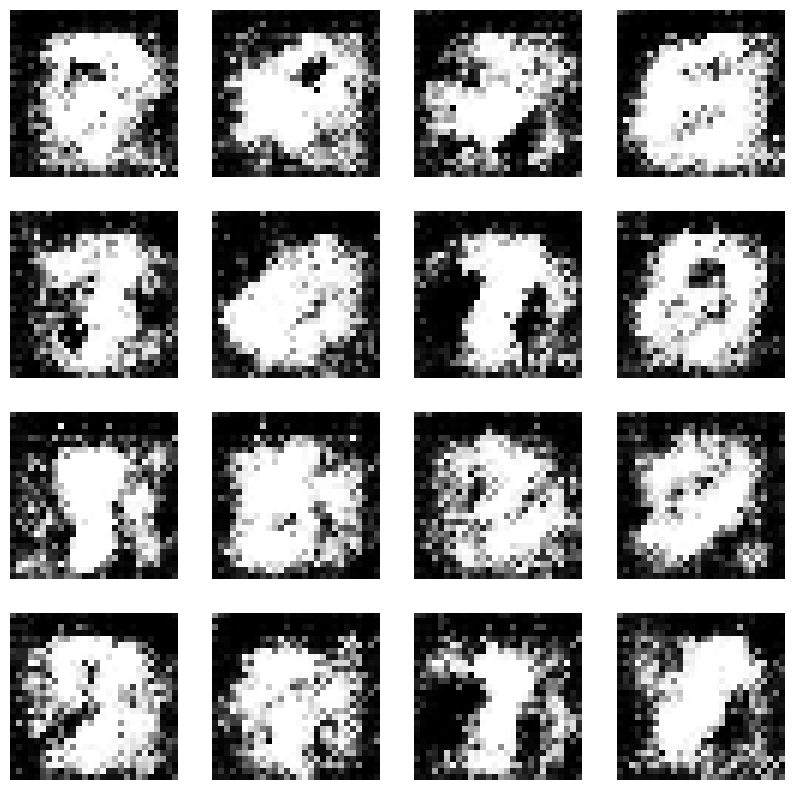

Epoch:  5


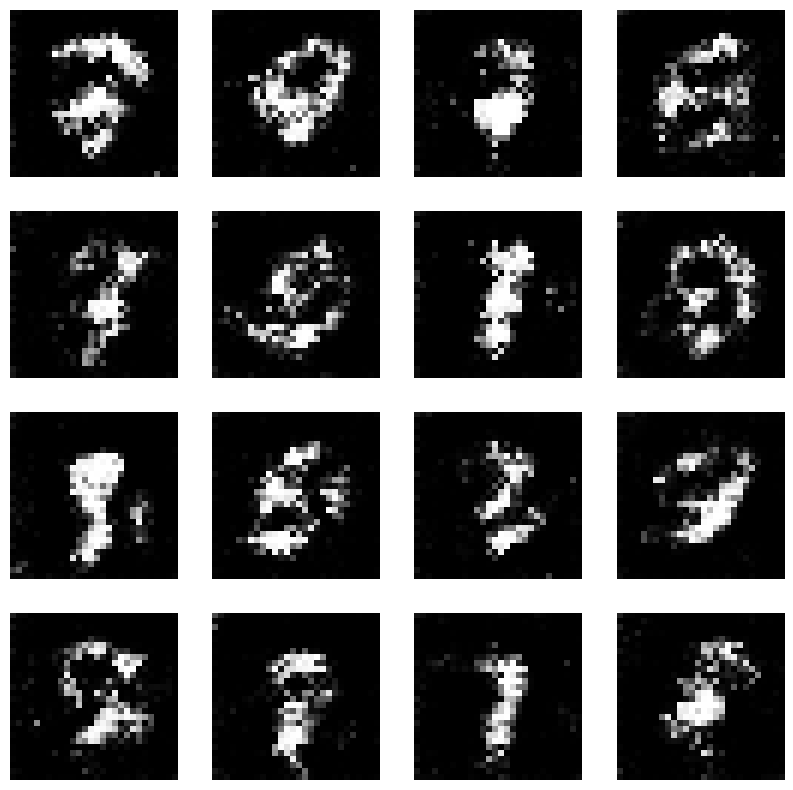

Epoch:  6


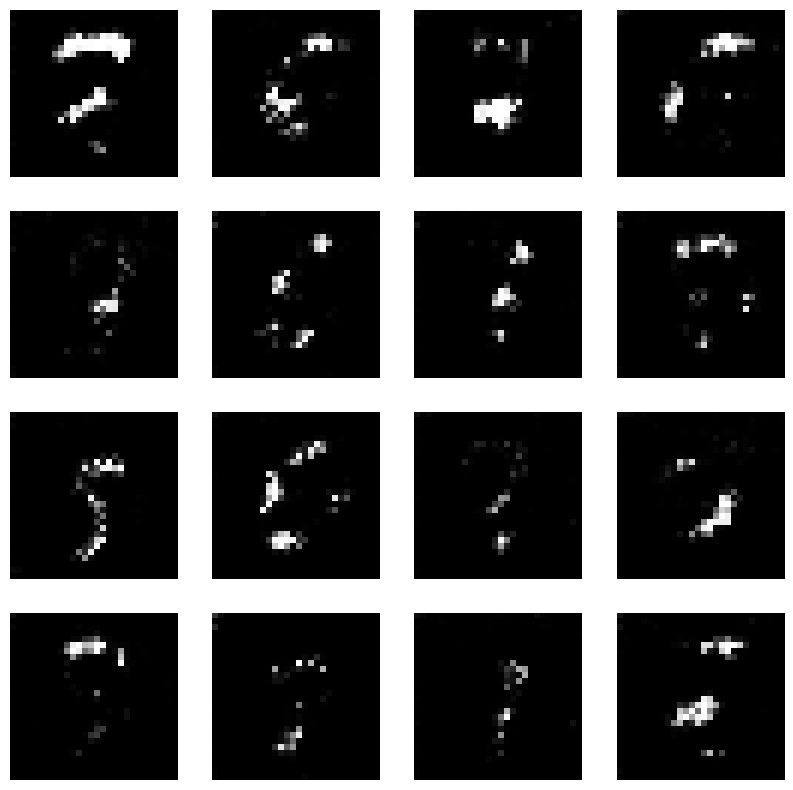

Epoch:  7


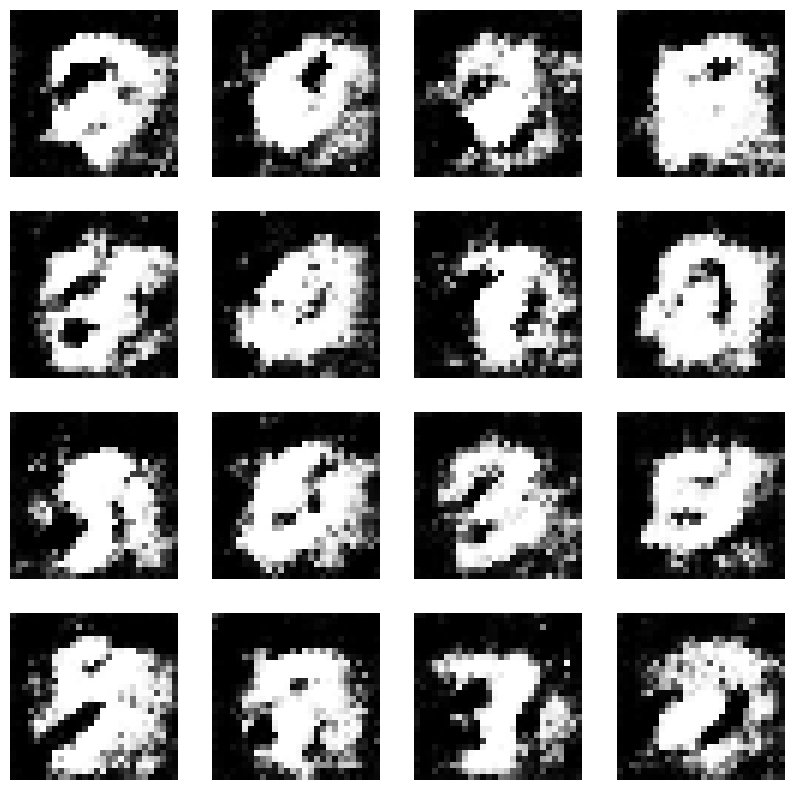

Epoch:  8


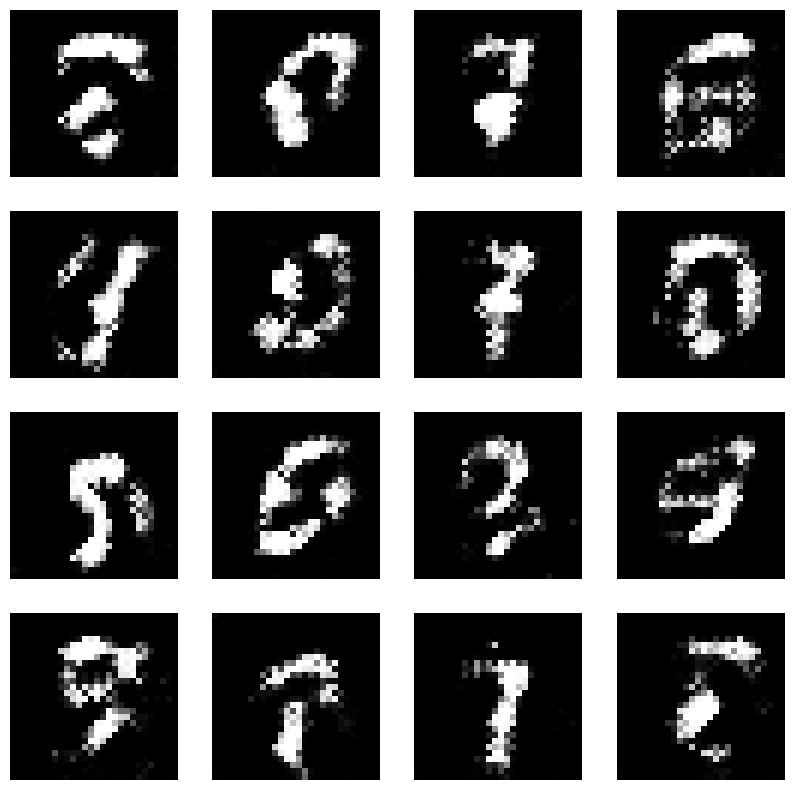

Epoch:  9


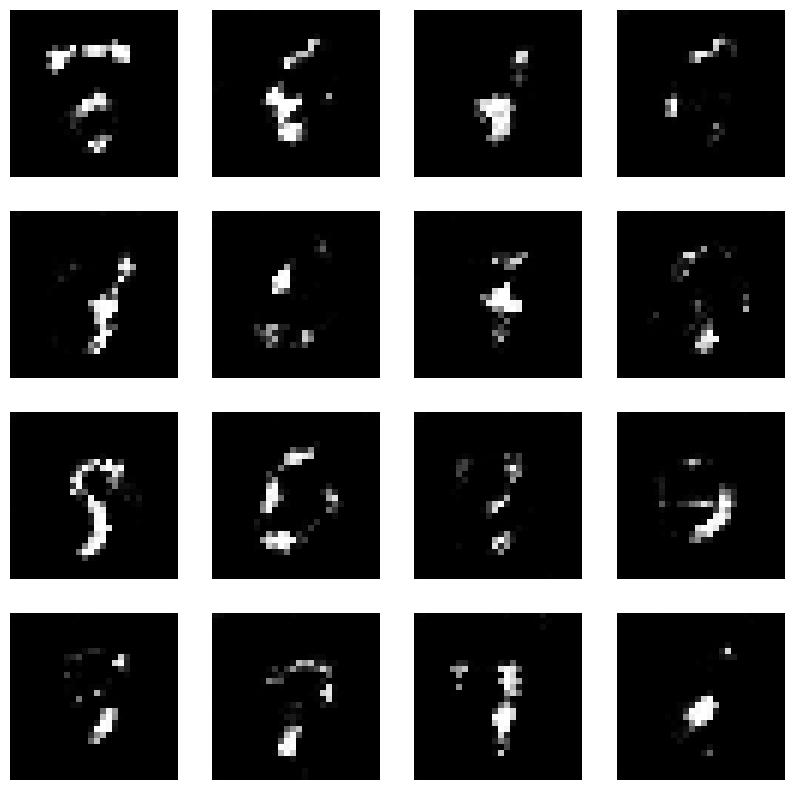

Epoch:  10


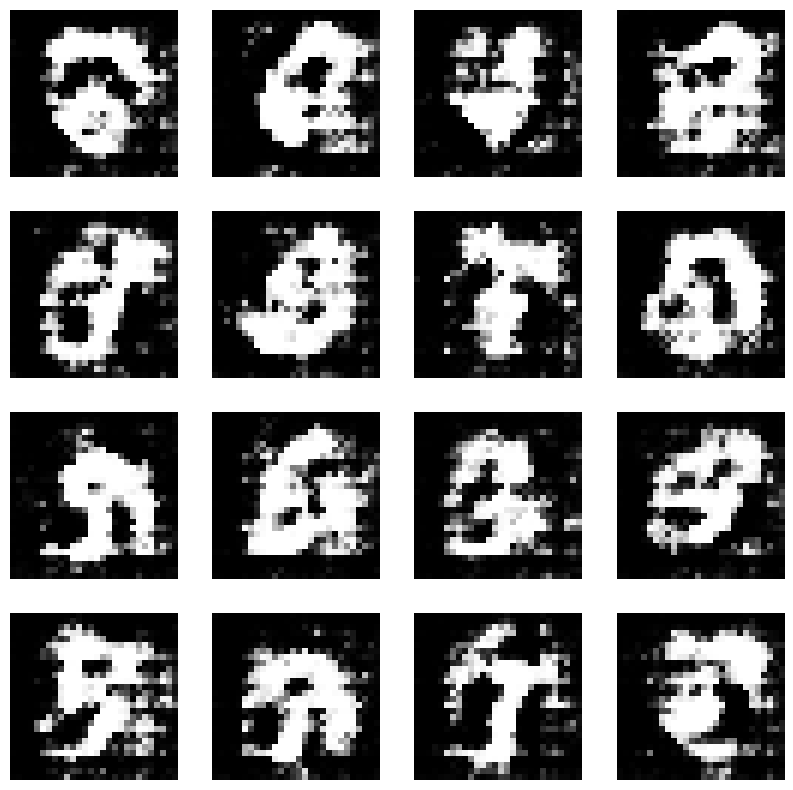

Epoch:  11


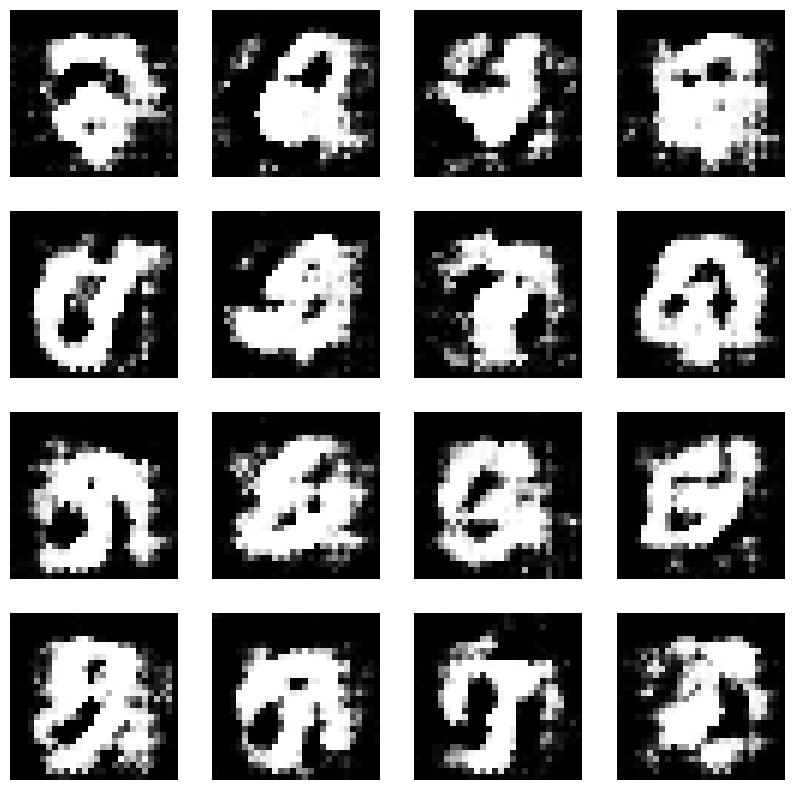

Epoch:  12


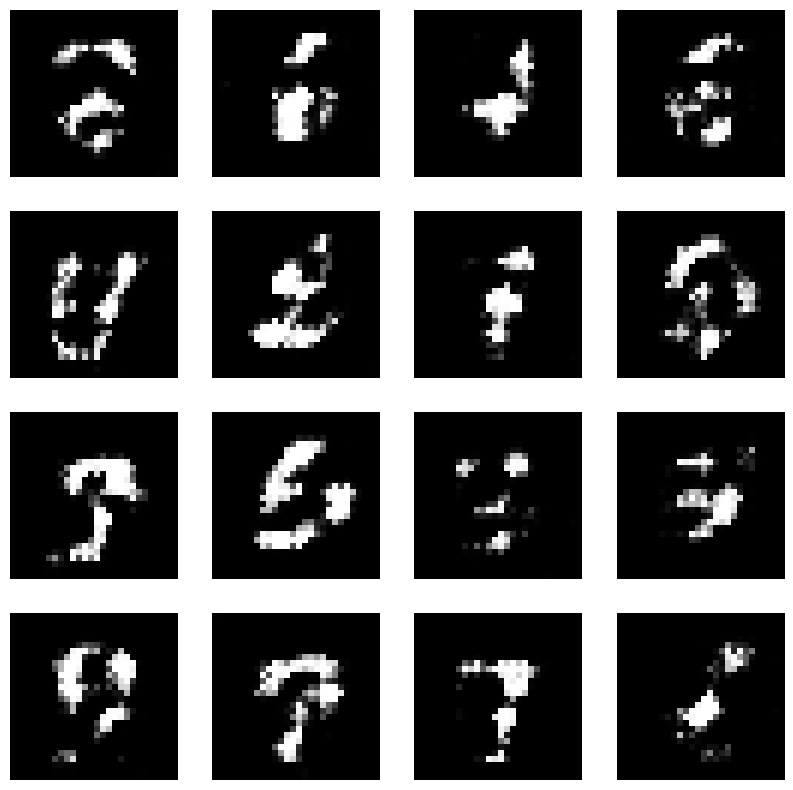

Epoch:  13


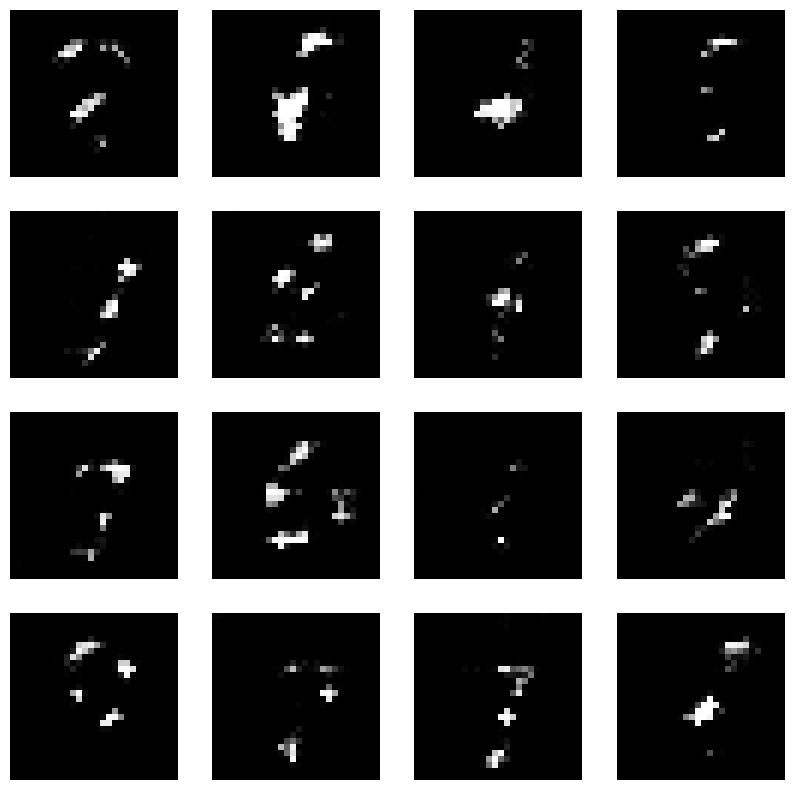

Epoch:  14


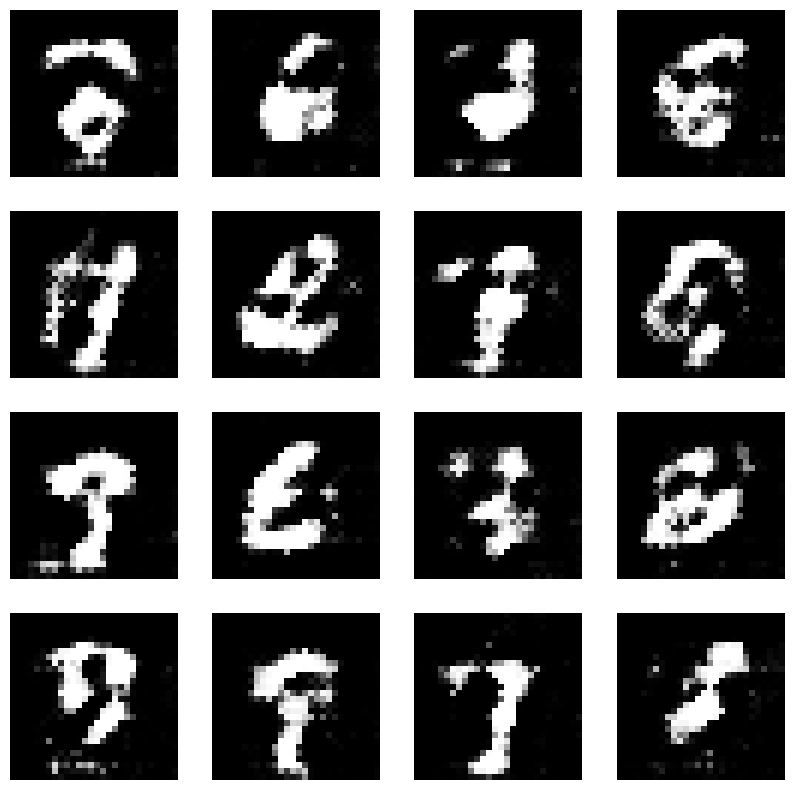

Epoch:  15


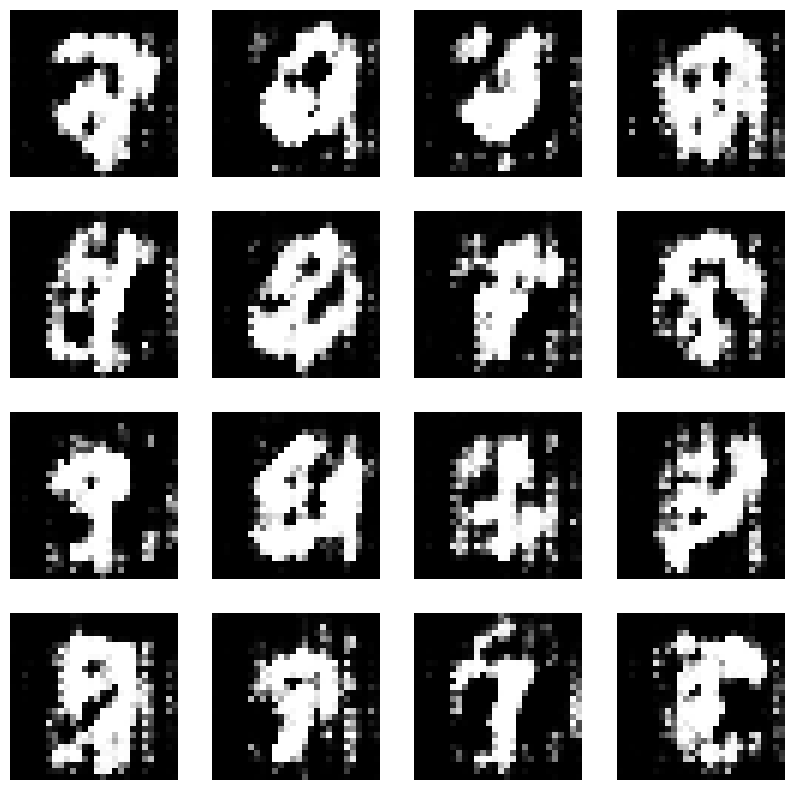

Epoch:  16


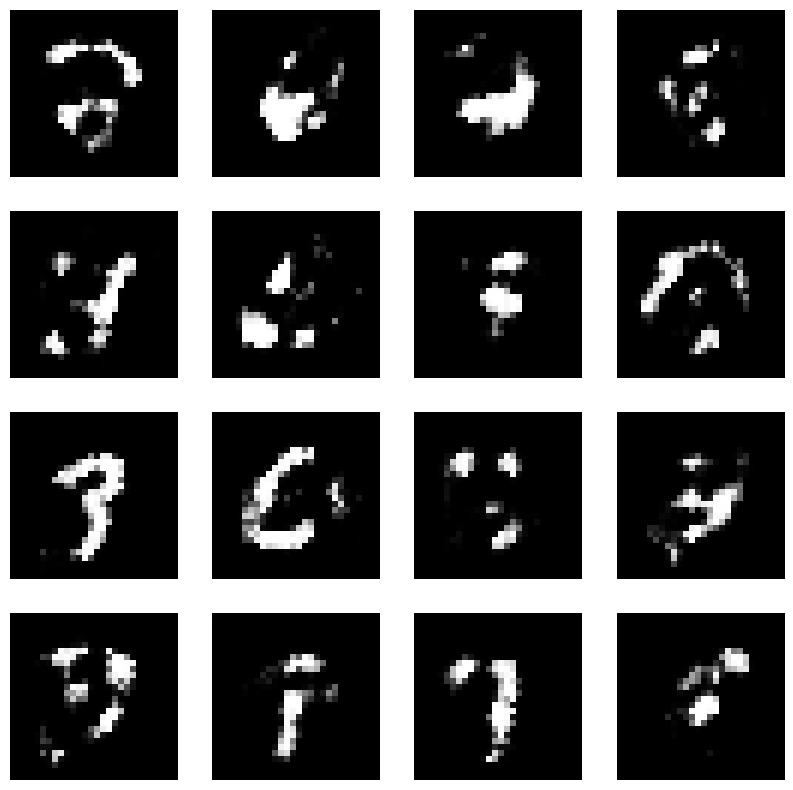

Epoch:  17


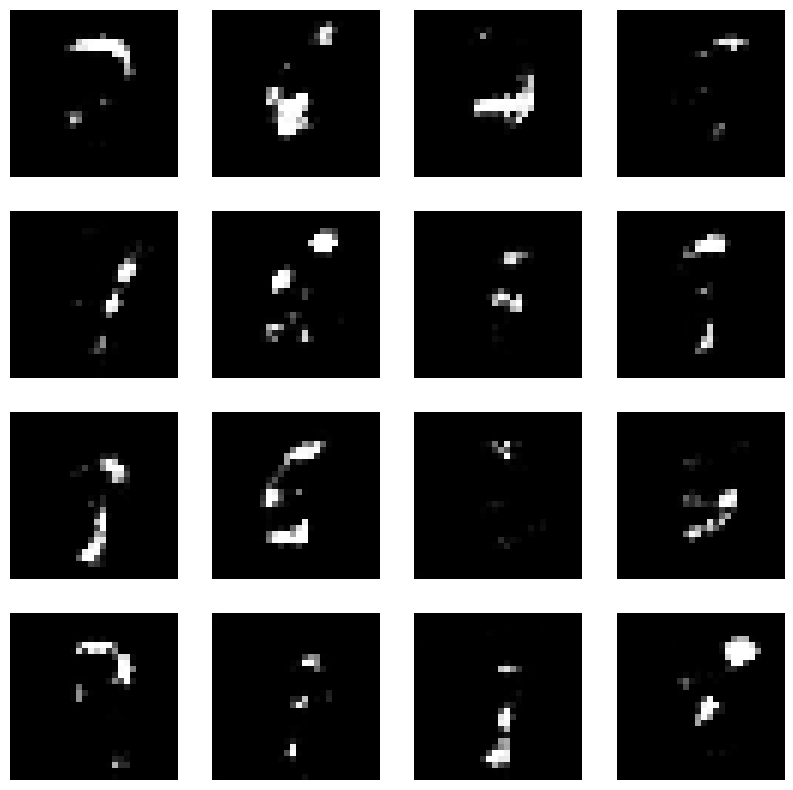

Epoch:  18


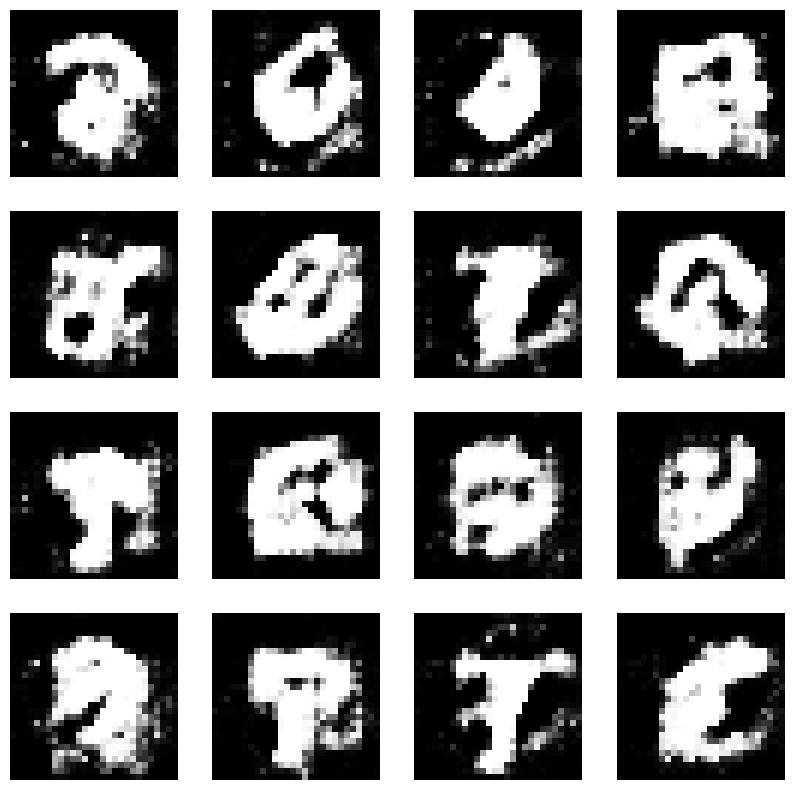

Epoch:  19


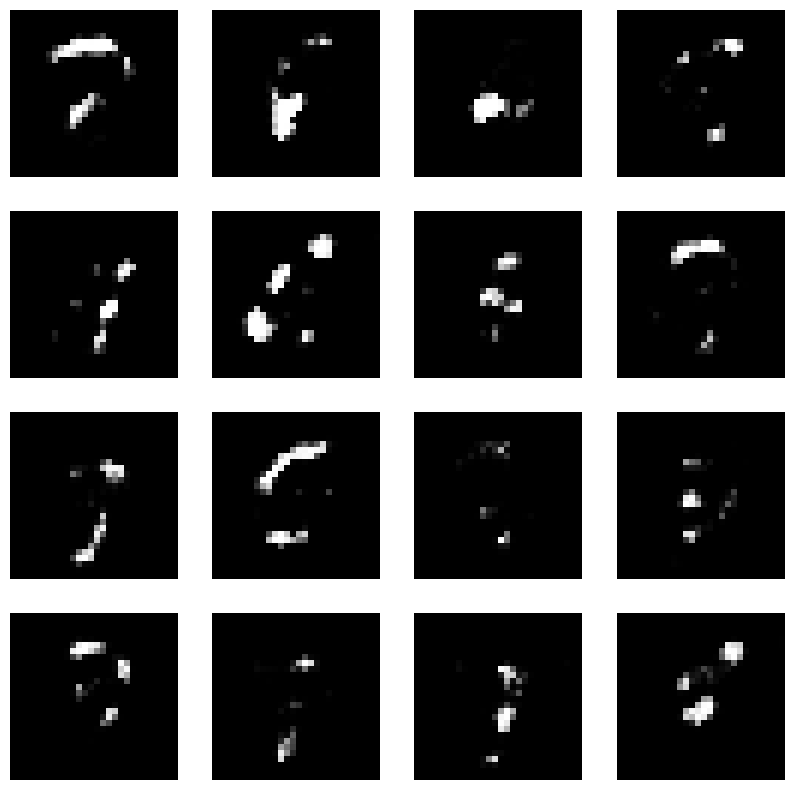

Epoch:  20


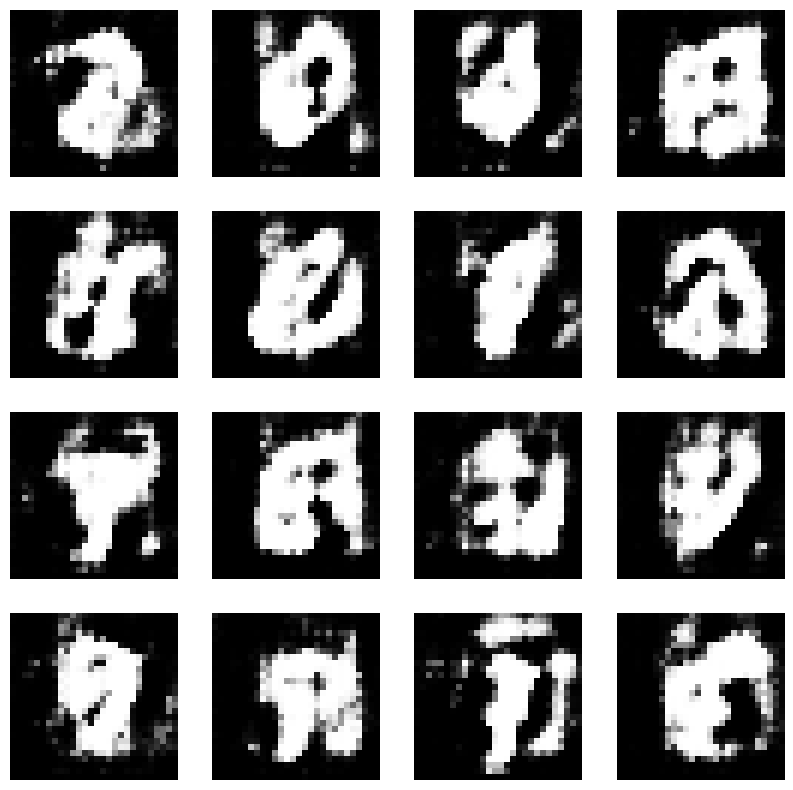

Epoch:  21


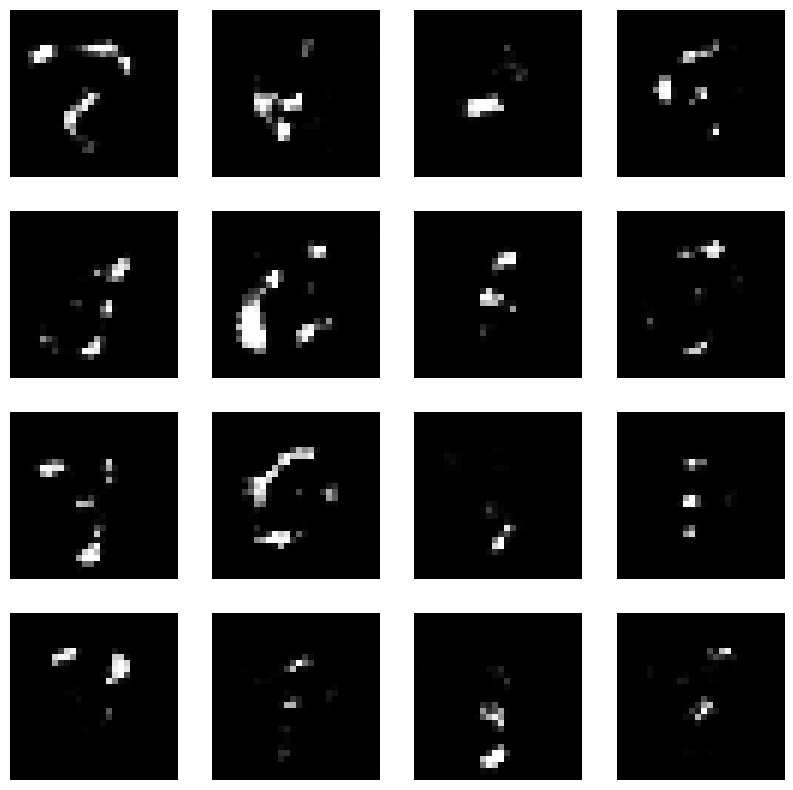

Epoch:  22


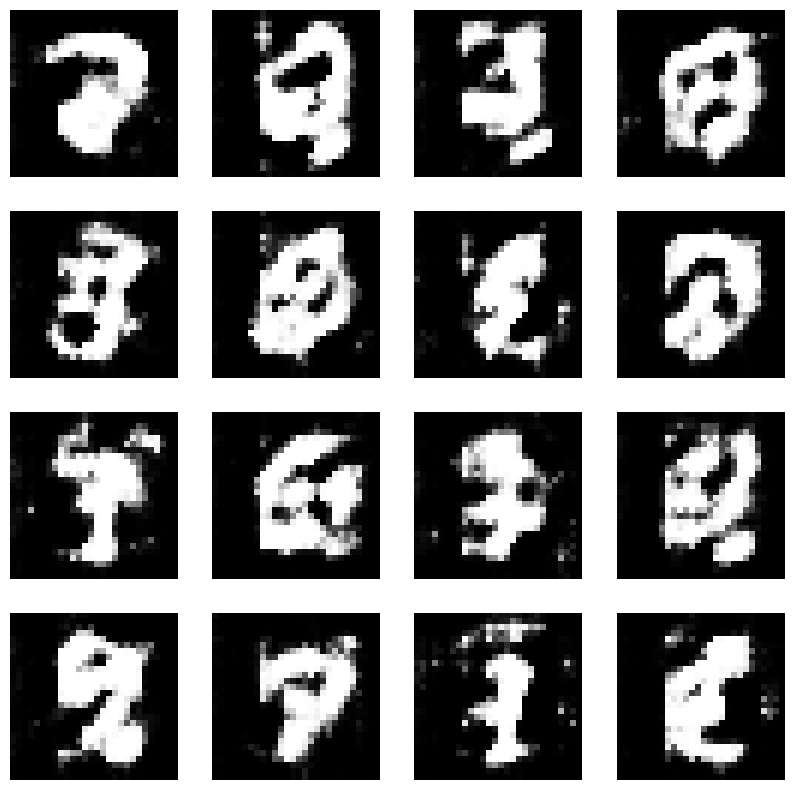

Epoch:  23


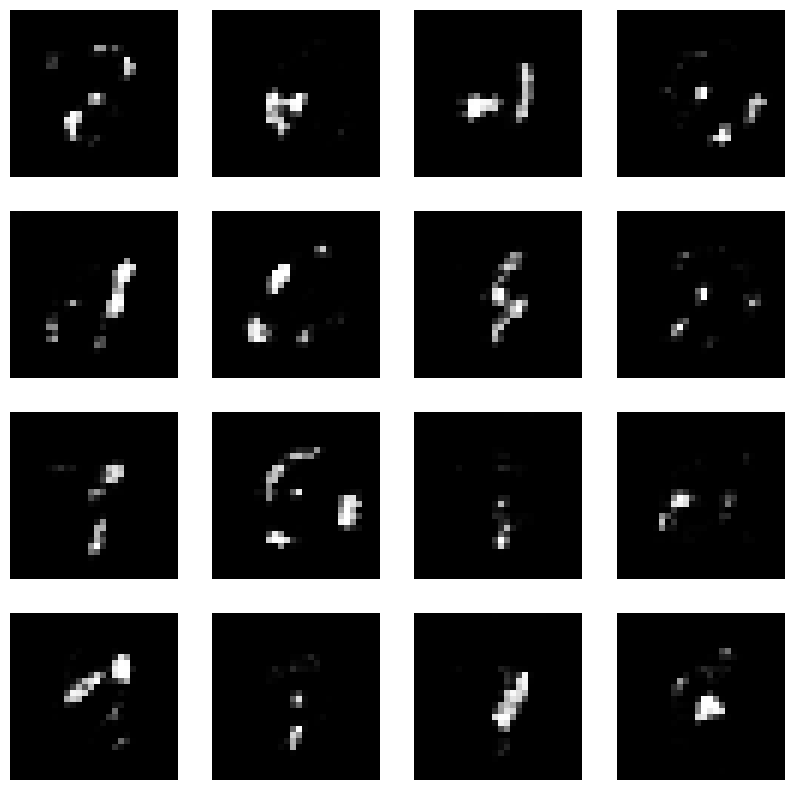

Epoch:  24


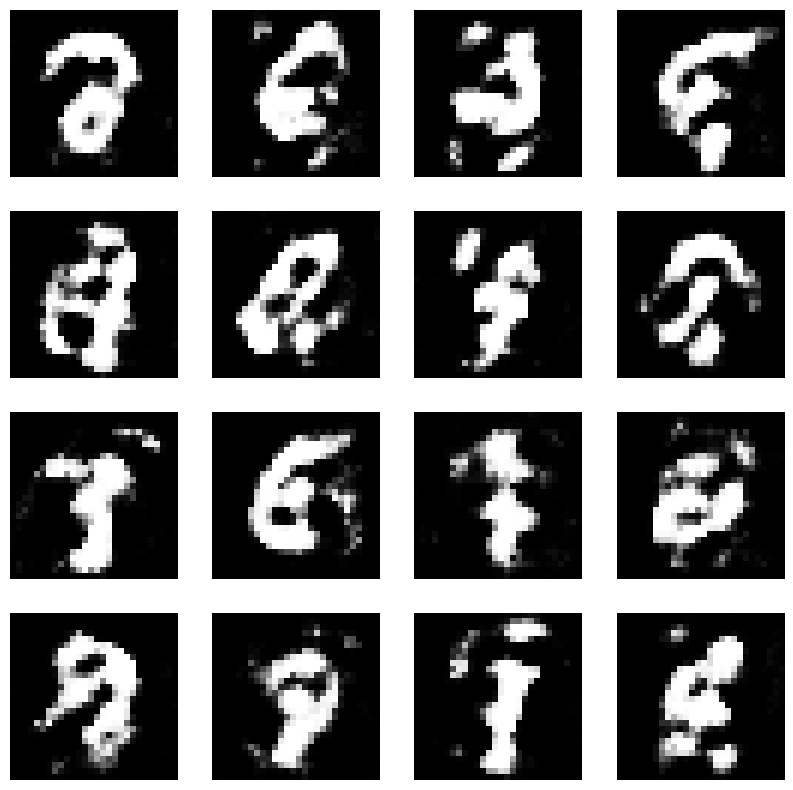

Epoch:  25


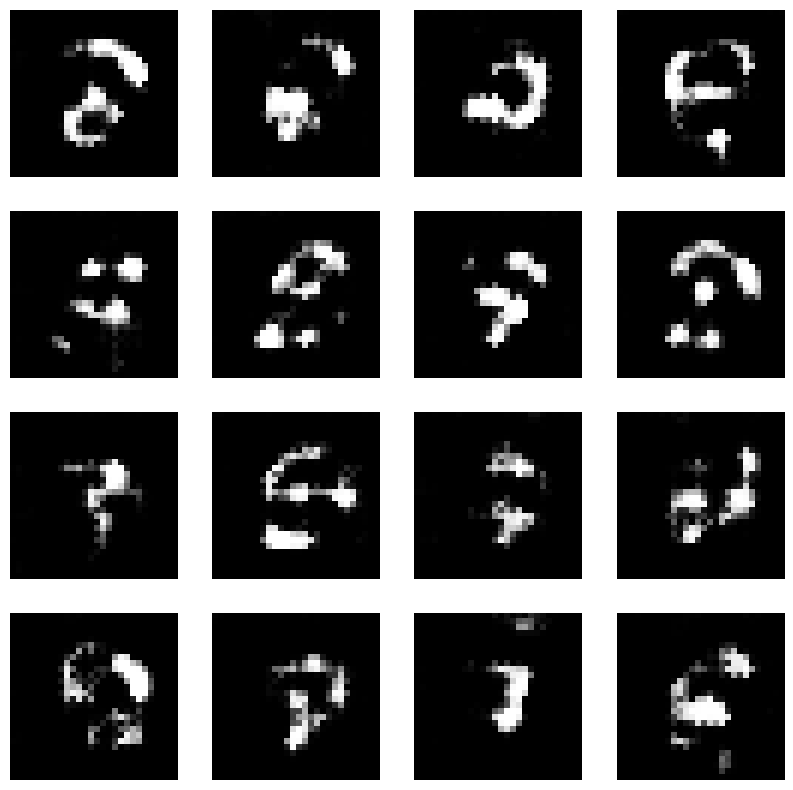

Epoch:  26


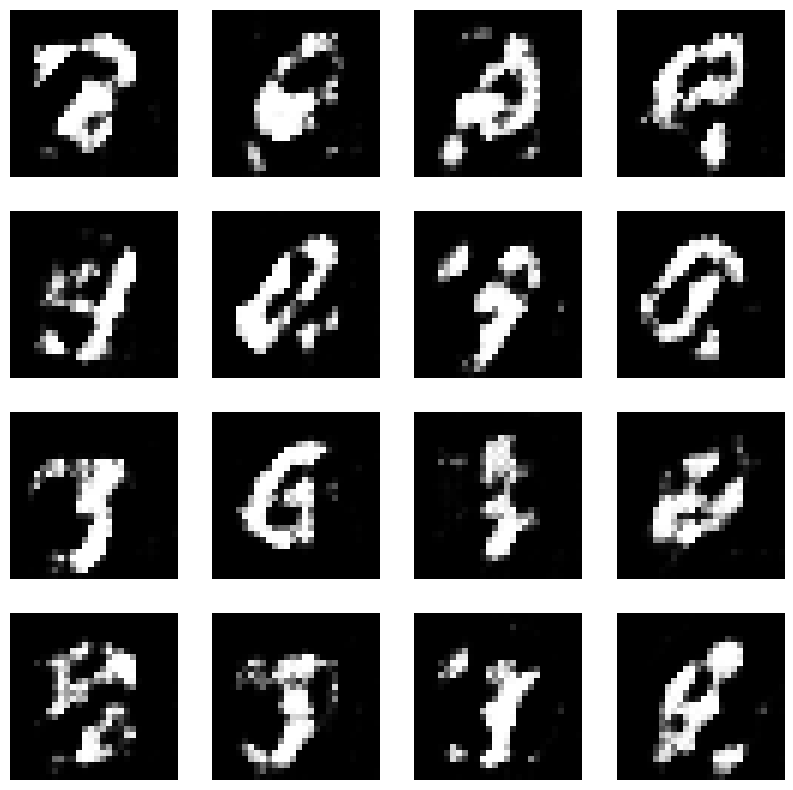

Epoch:  27


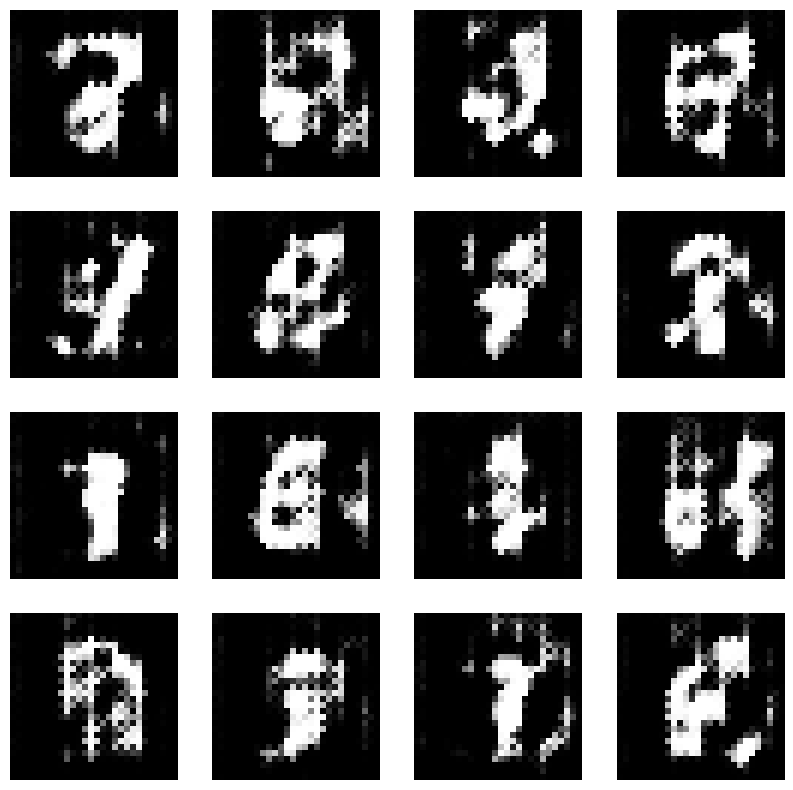

Epoch:  28


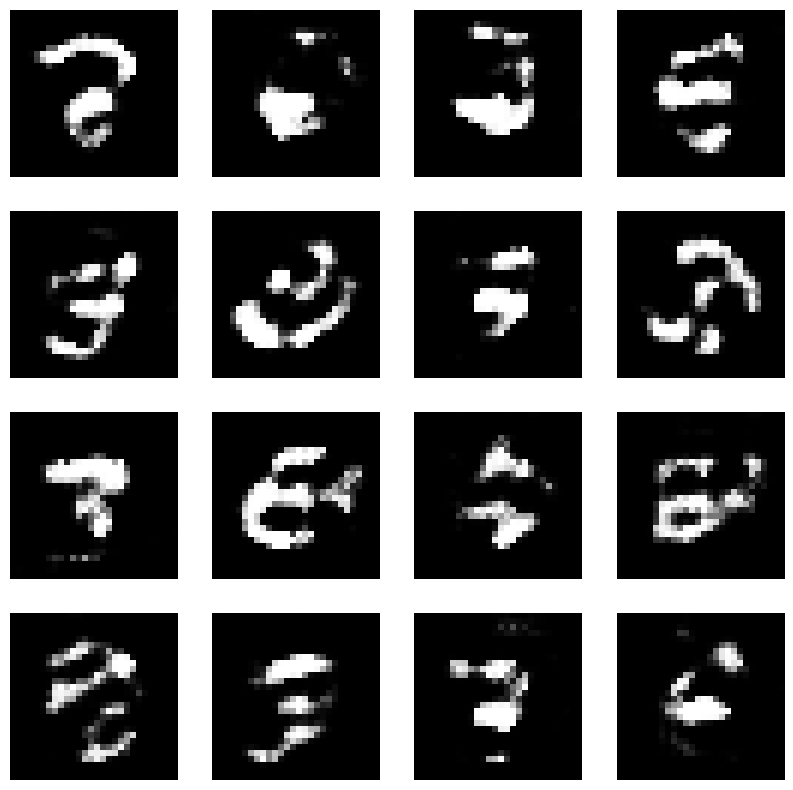

Epoch:  29


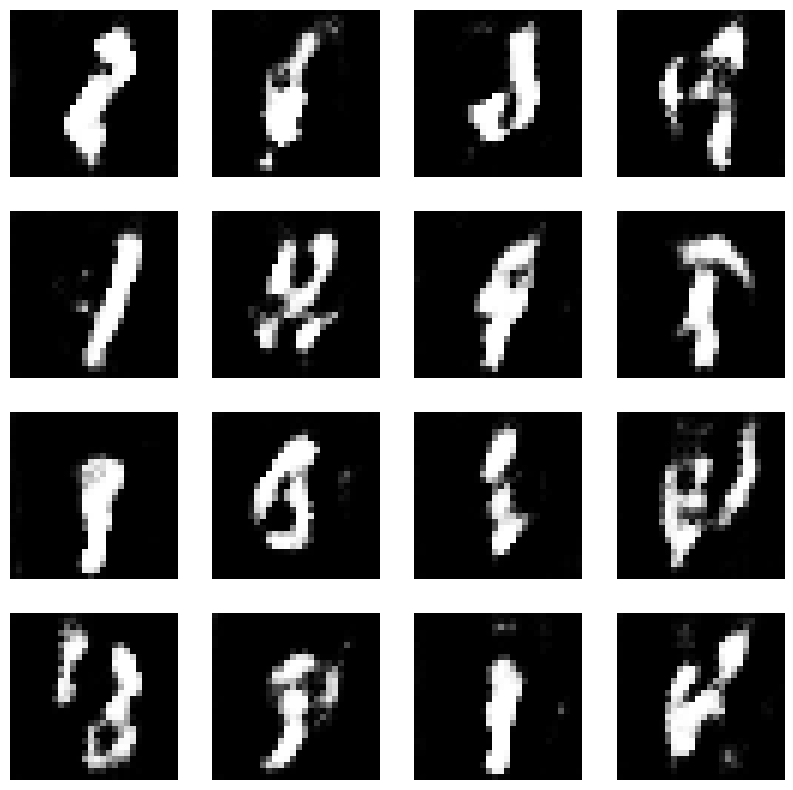

Epoch:  30


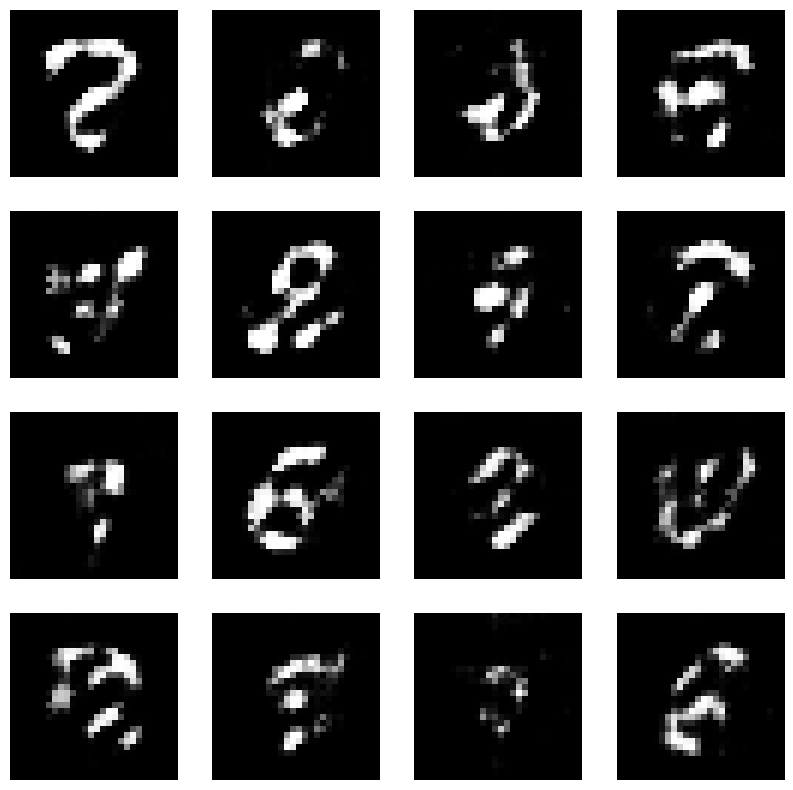

Epoch:  31


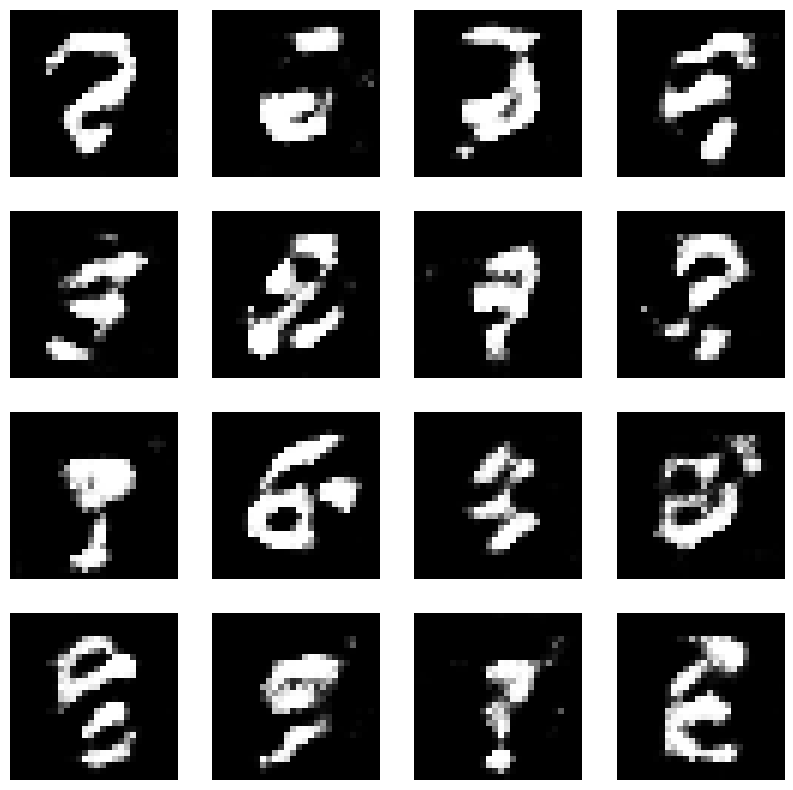

Epoch:  32


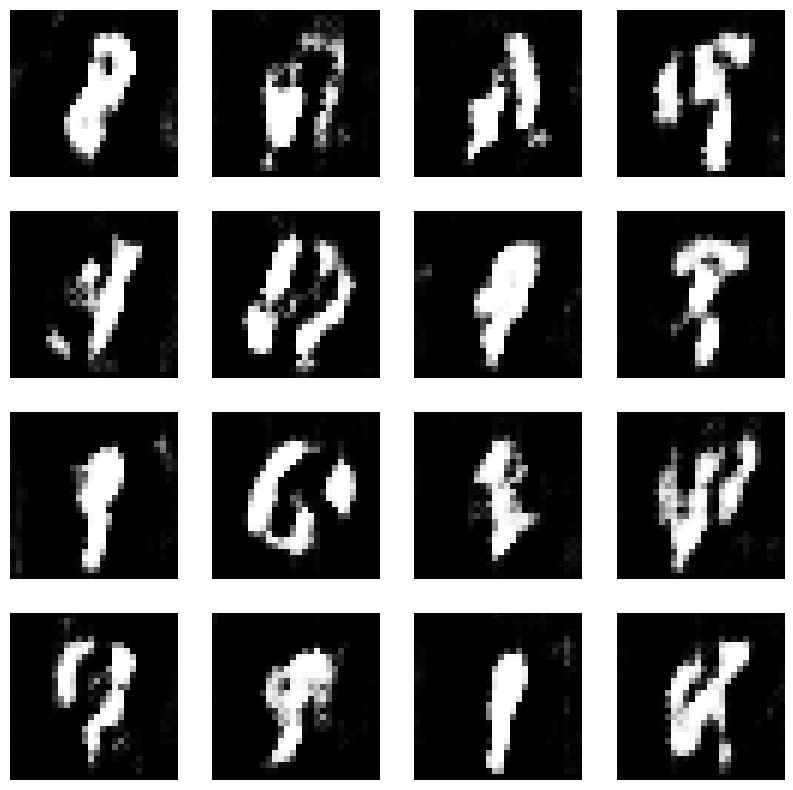

Epoch:  33


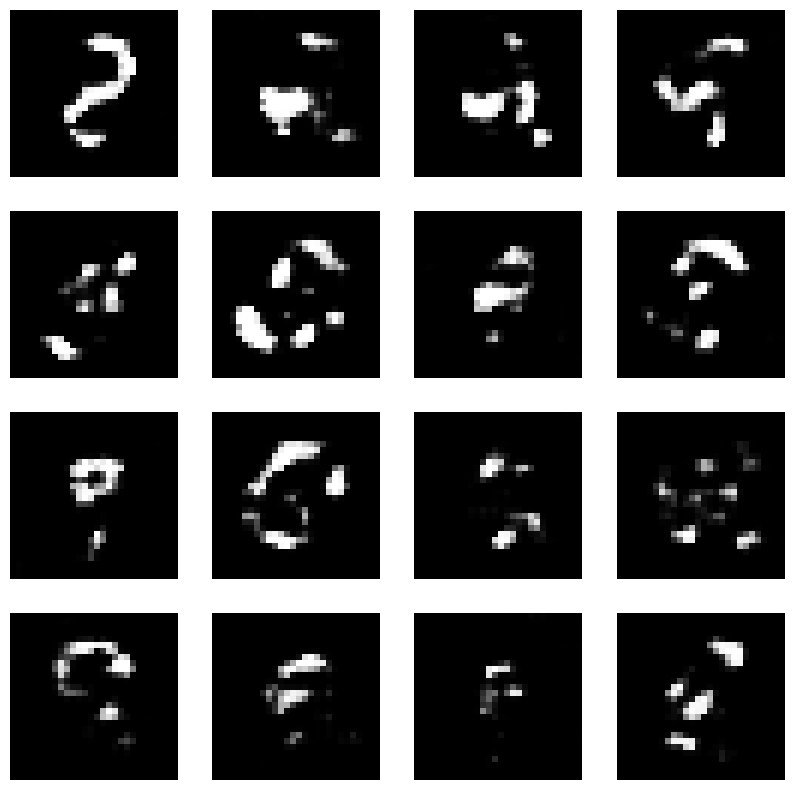

Epoch:  34


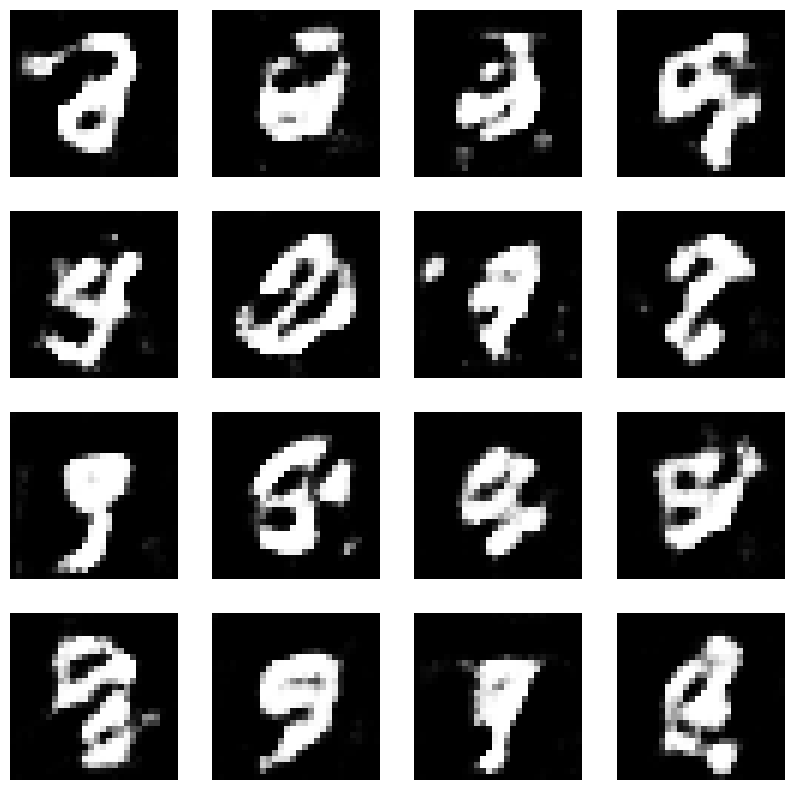

Epoch:  35


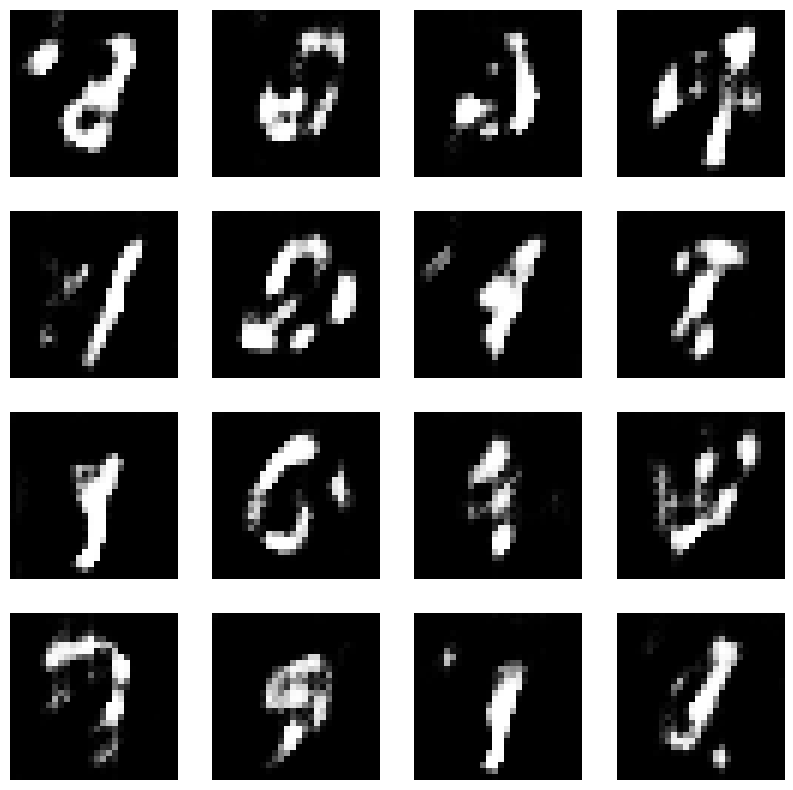

Epoch:  36


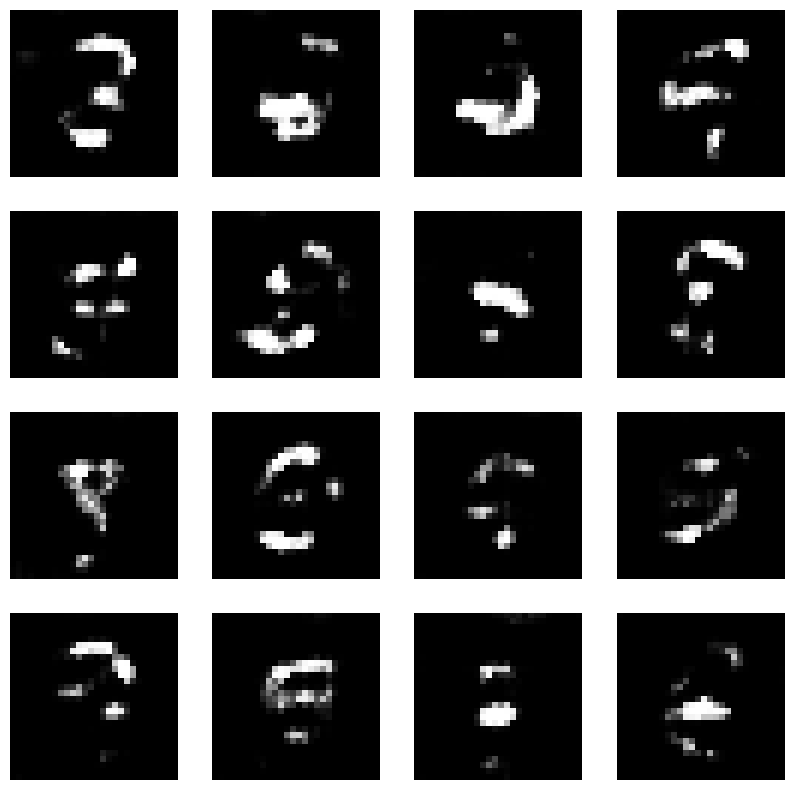

Epoch:  37


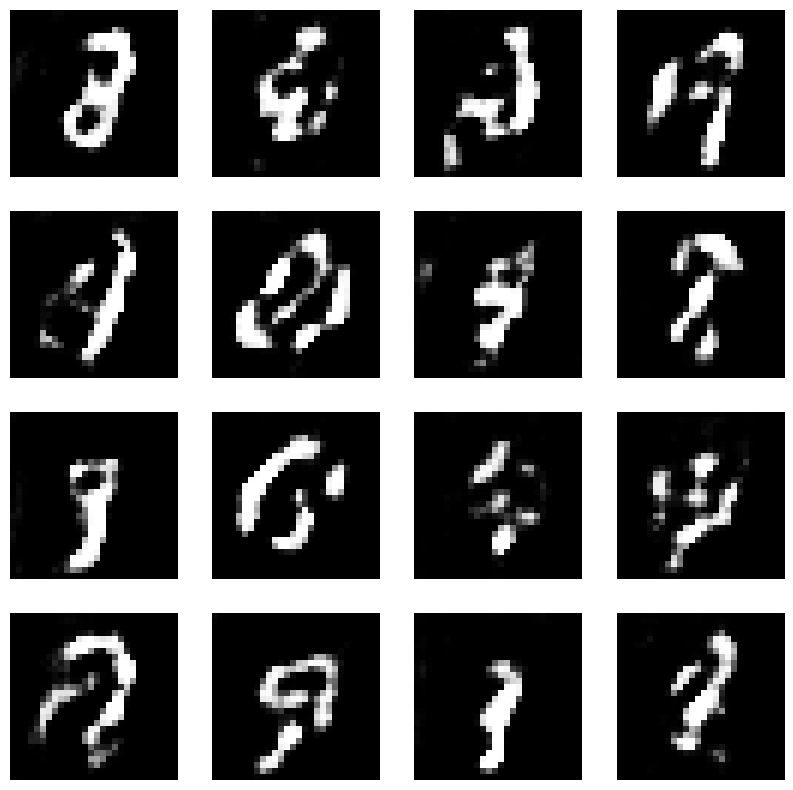

Epoch:  38


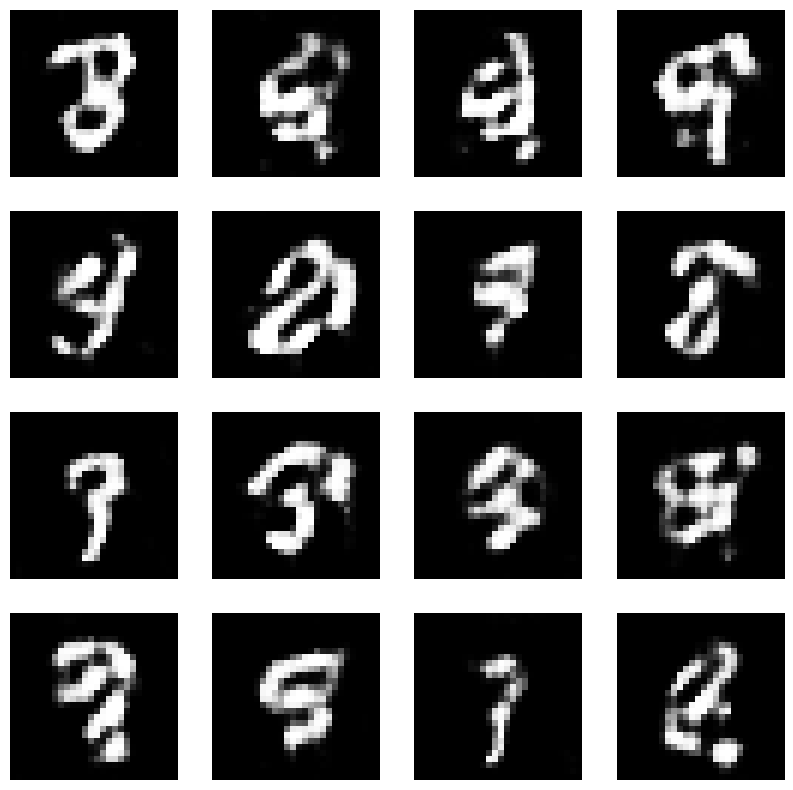

Epoch:  39


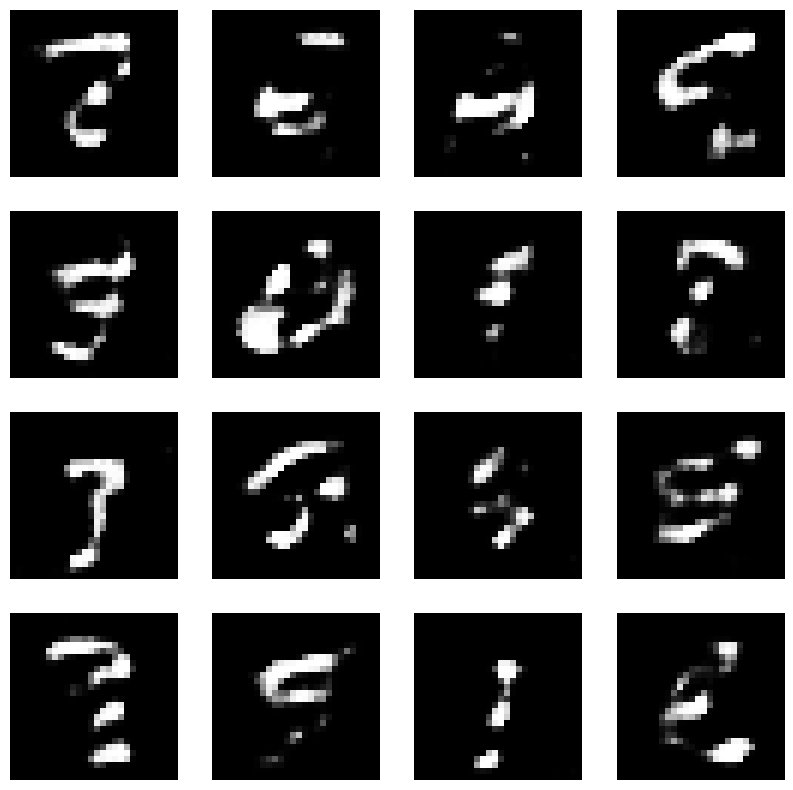

Epoch:  40


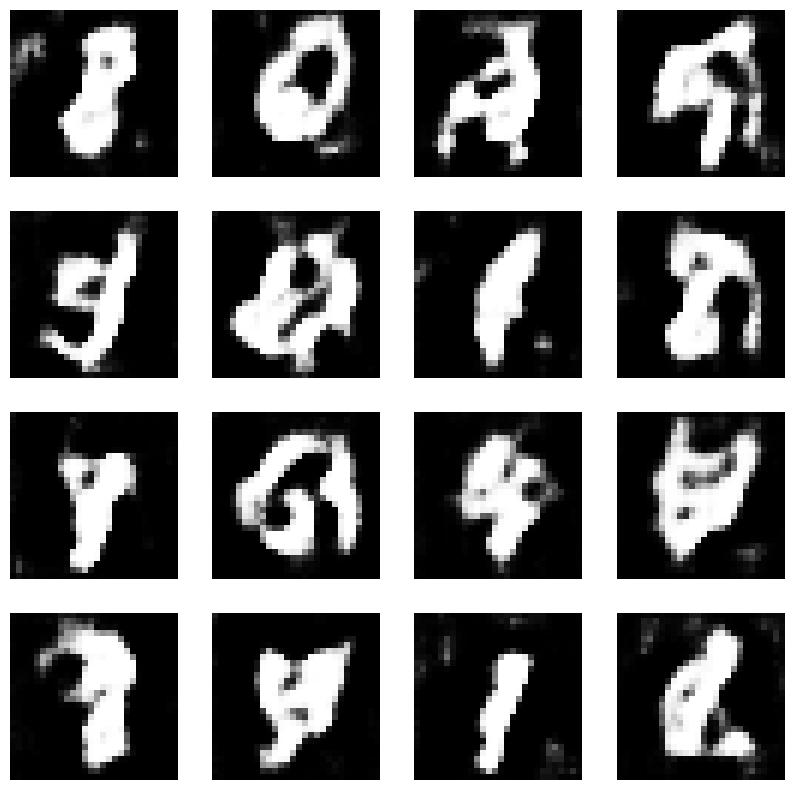

Epoch:  41


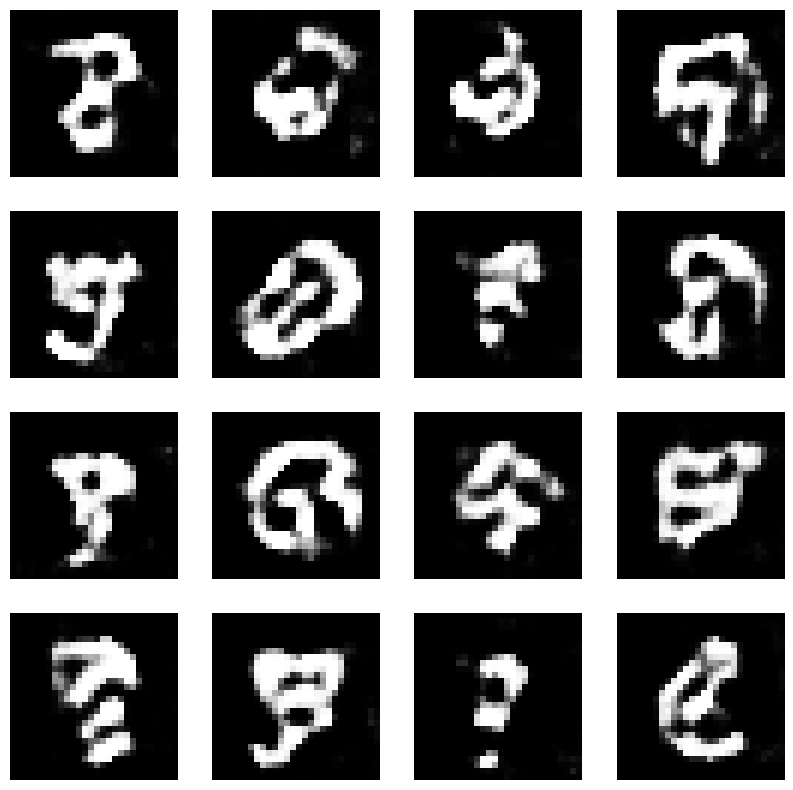

Epoch:  42


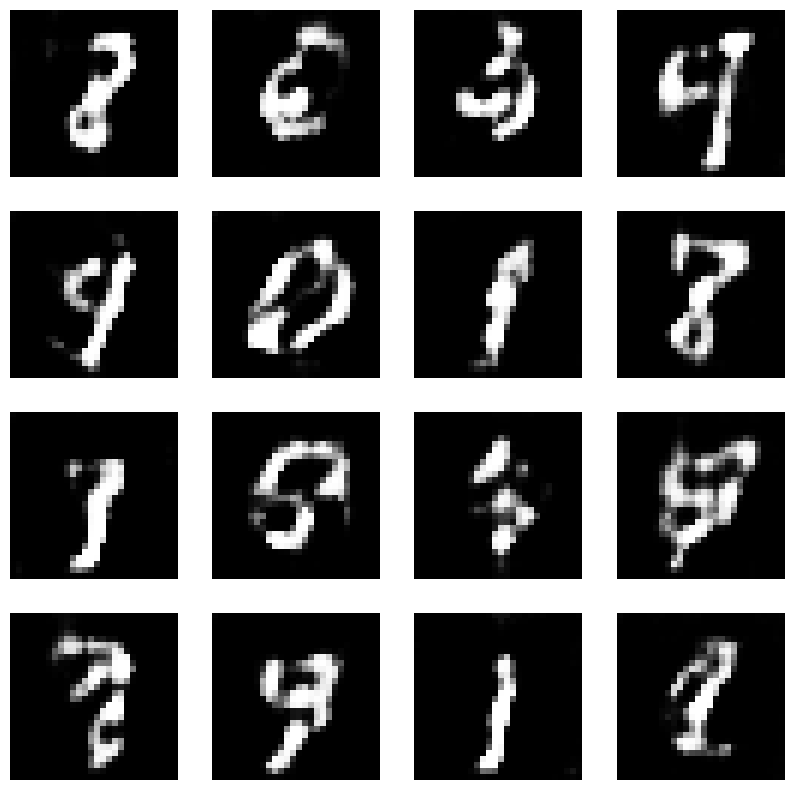

Epoch:  43


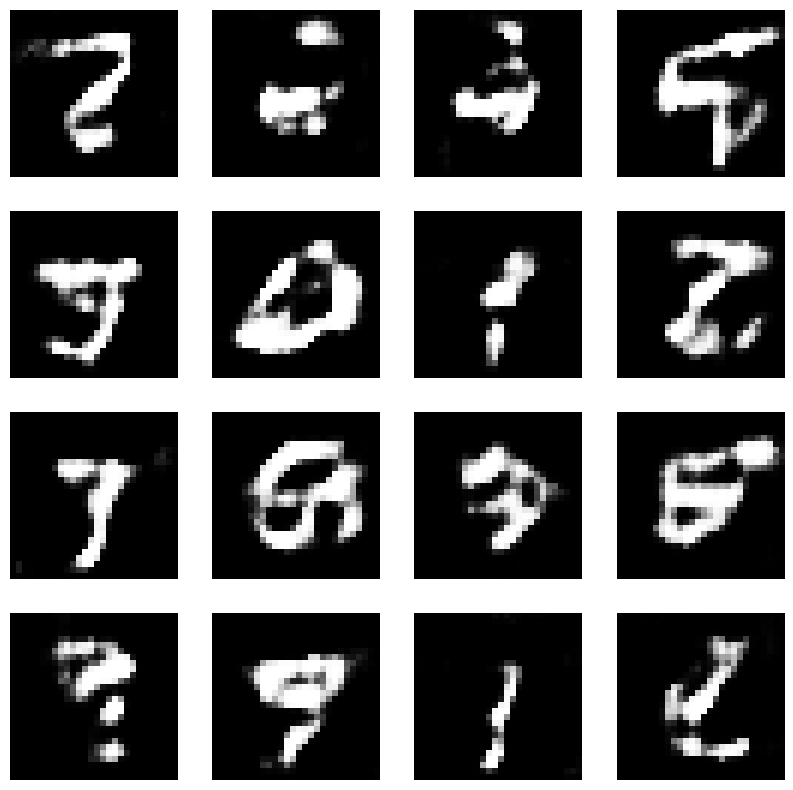

Epoch:  44


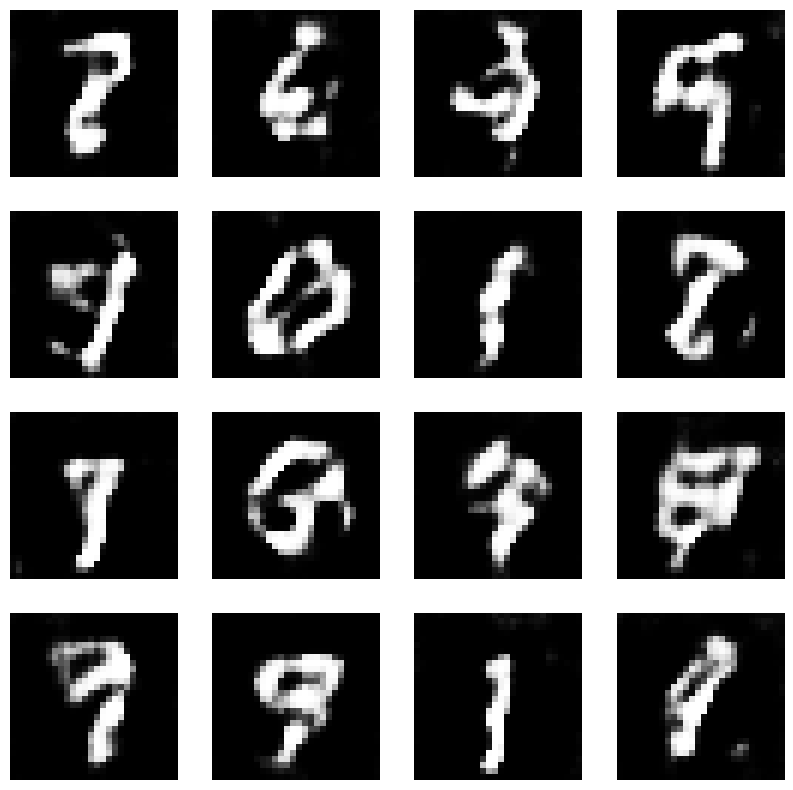

Epoch:  45


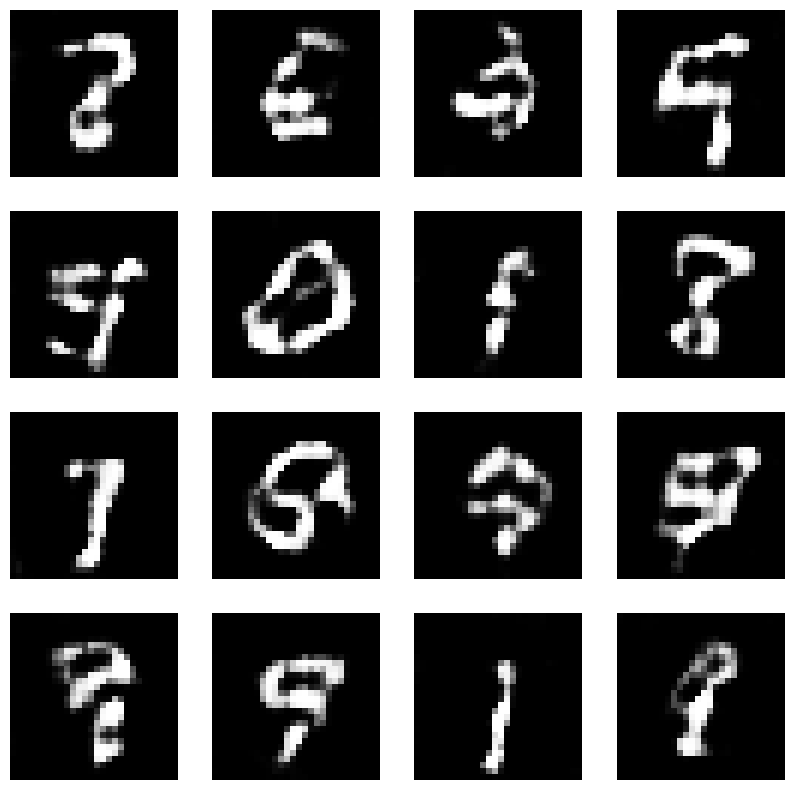

Epoch:  46


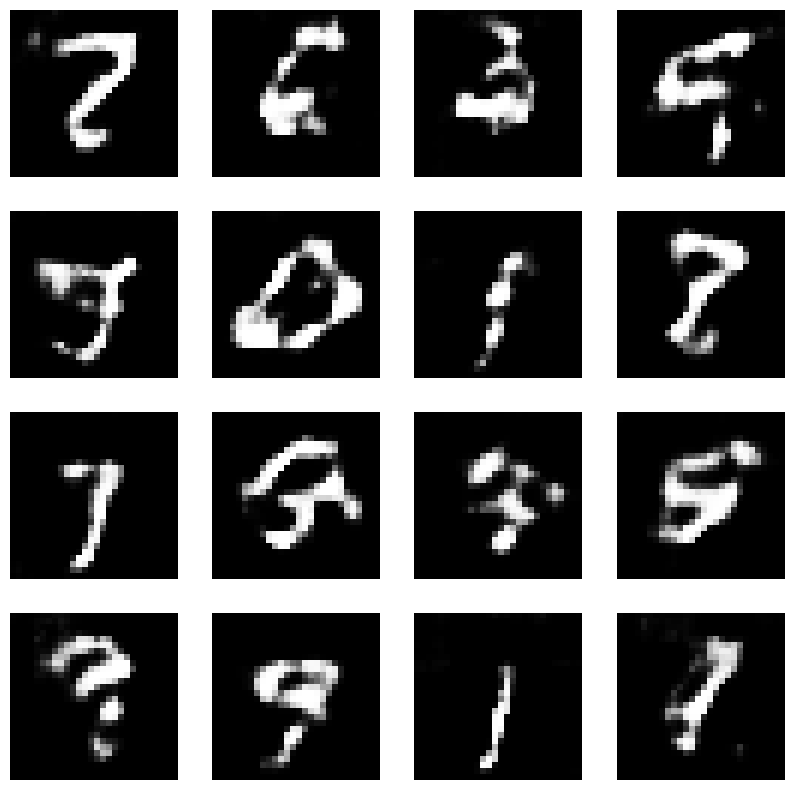

Epoch:  47


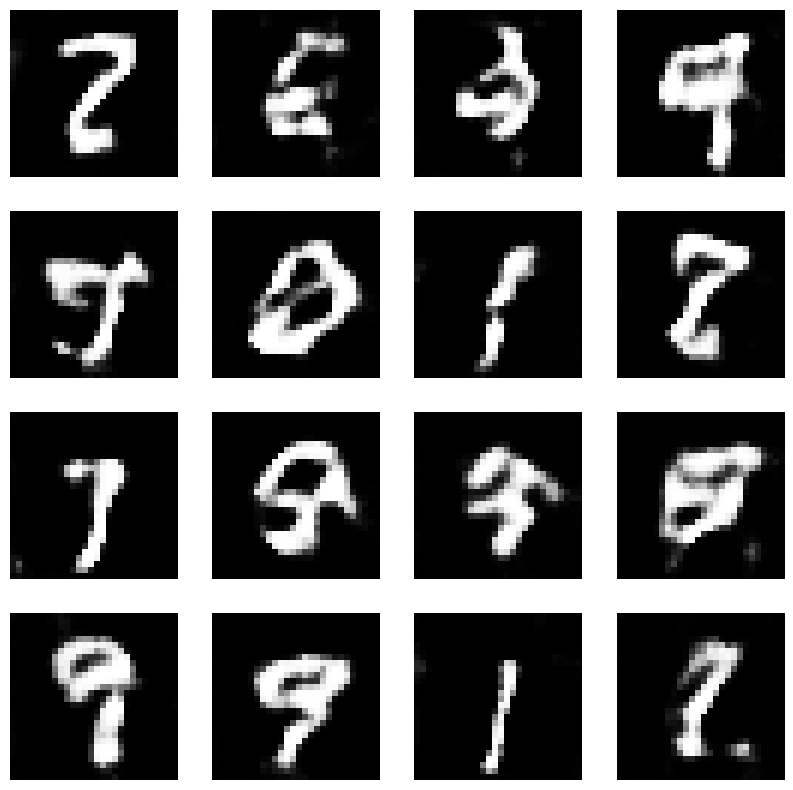

Epoch:  48


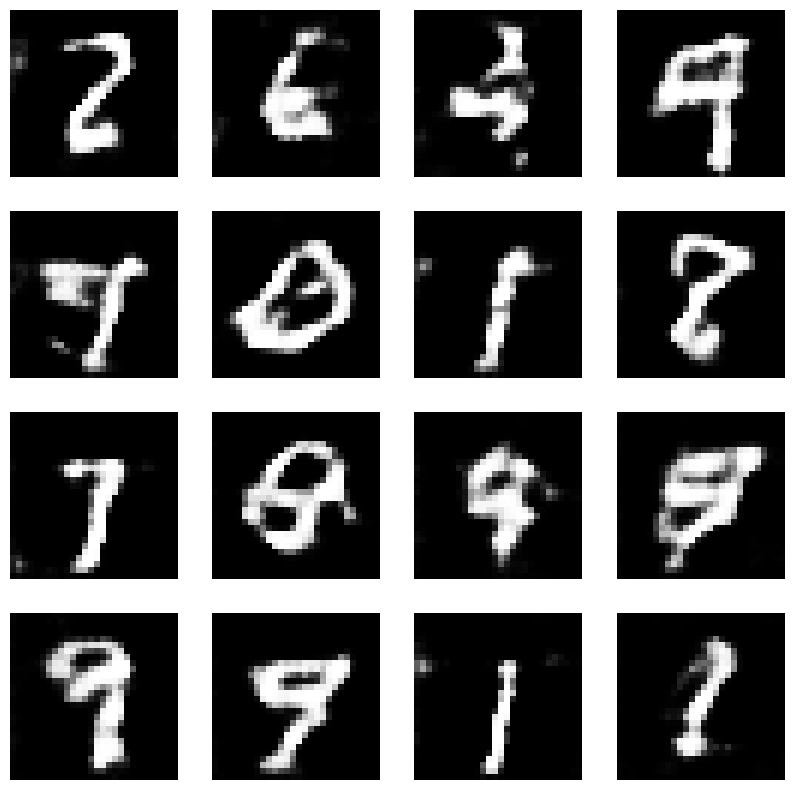

Epoch:  49


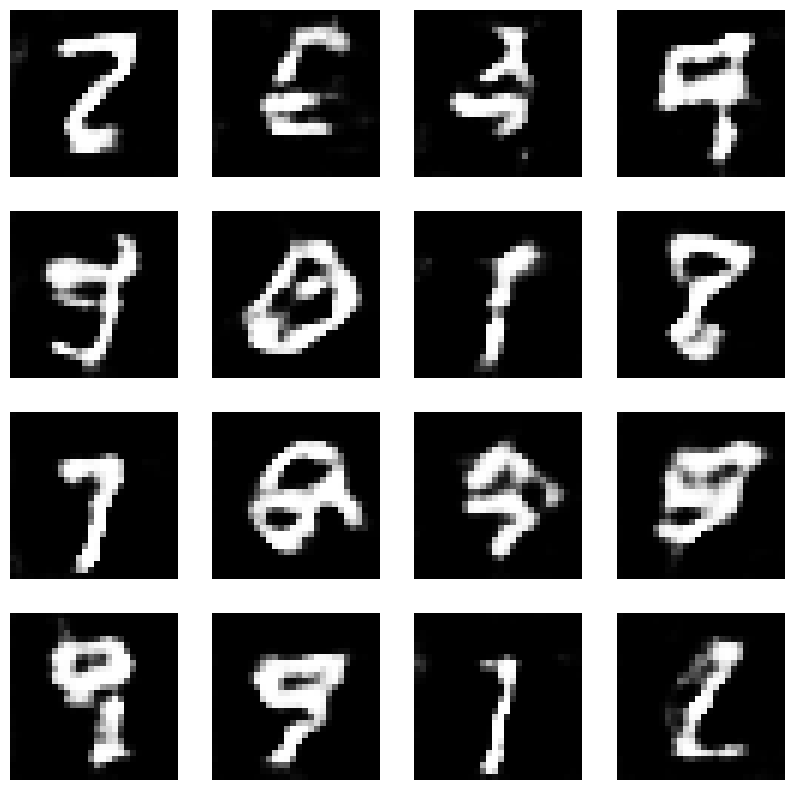

Epoch:  50


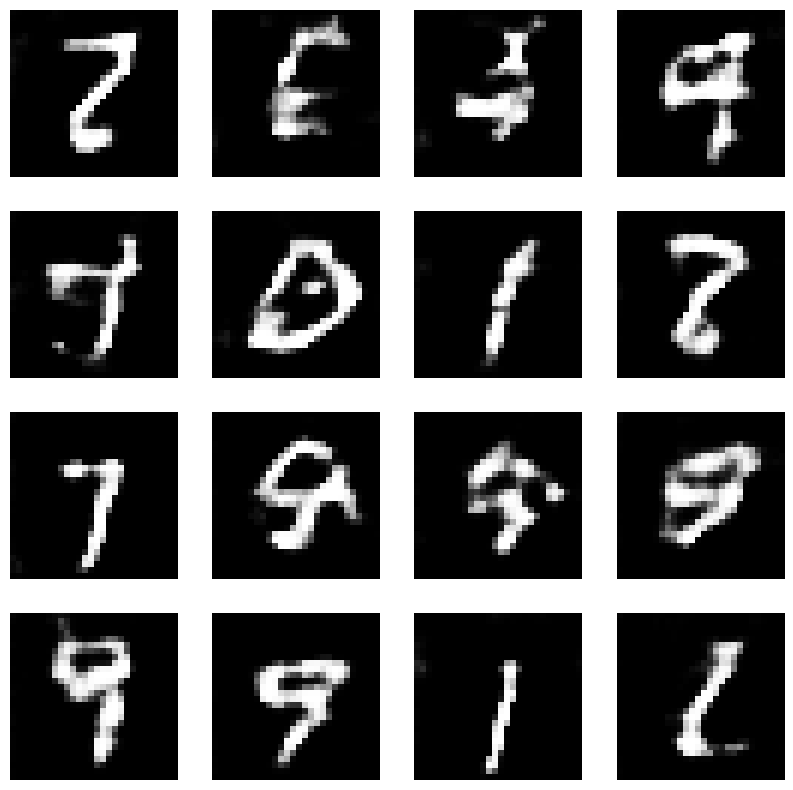

Epoch:  51


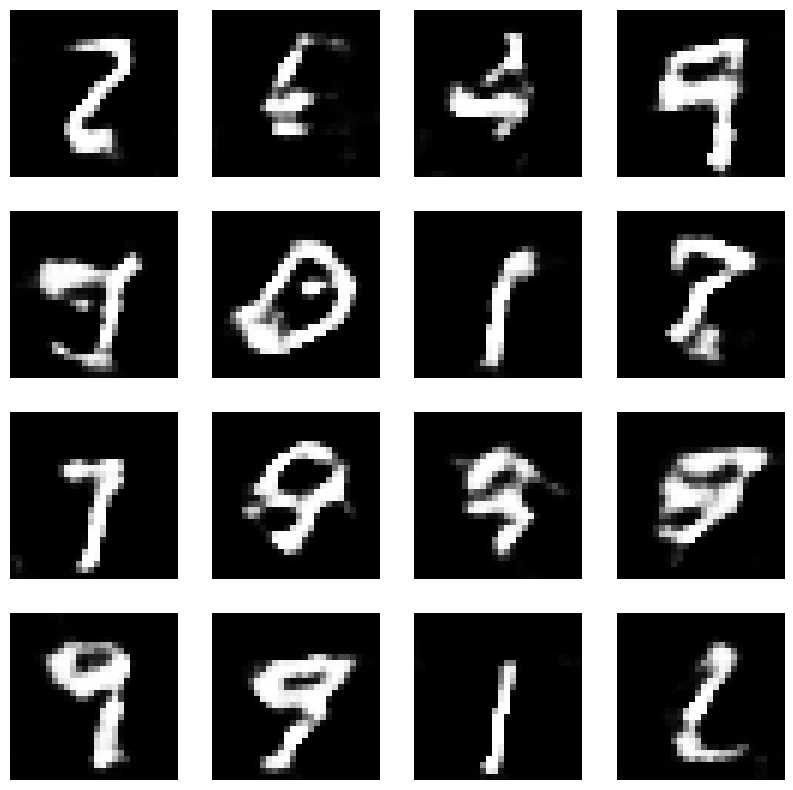

Epoch:  52


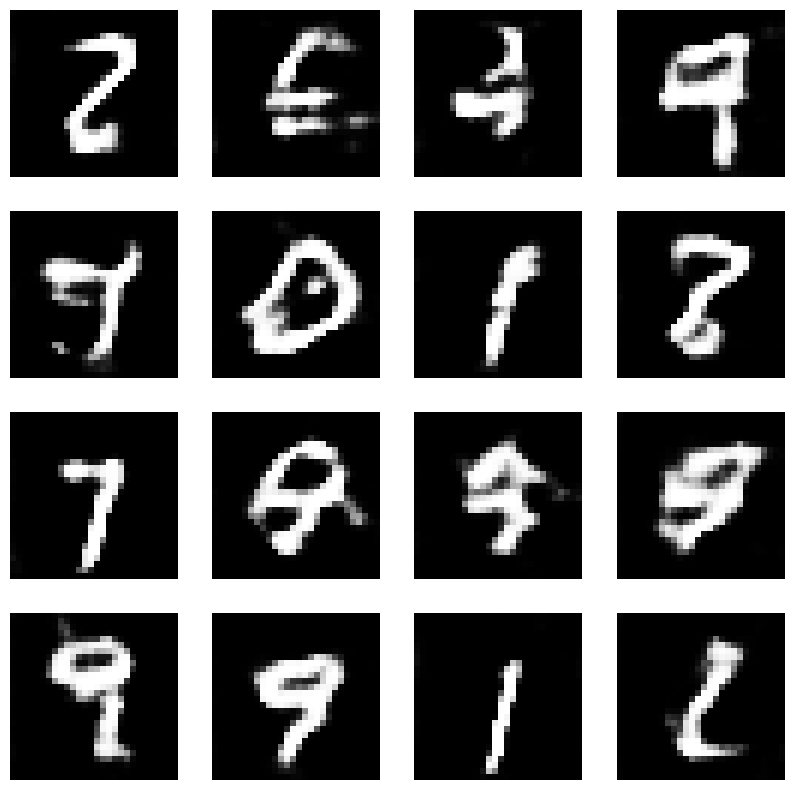

Epoch:  53


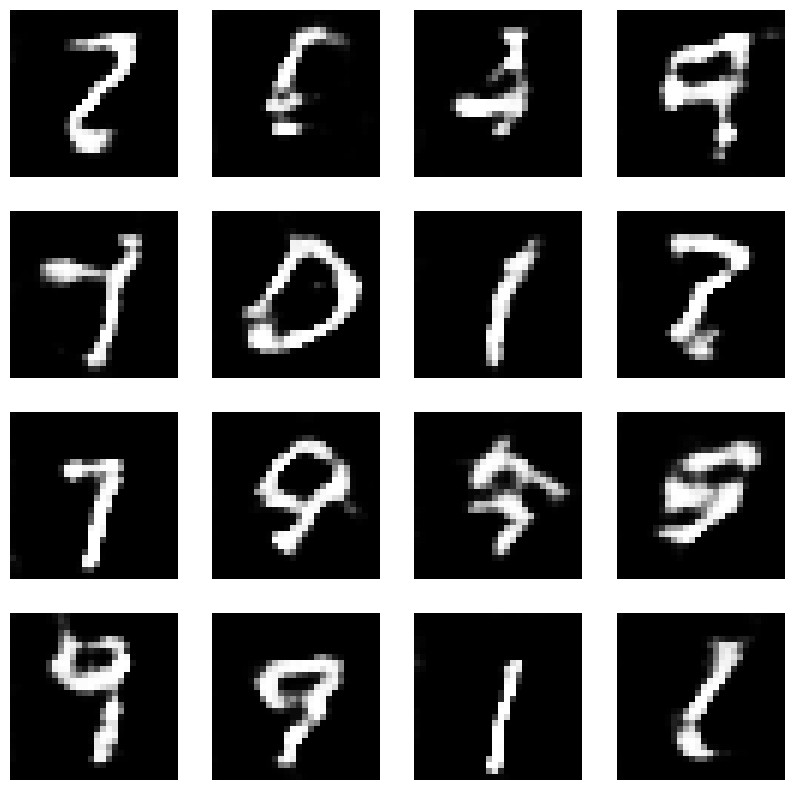

Epoch:  54


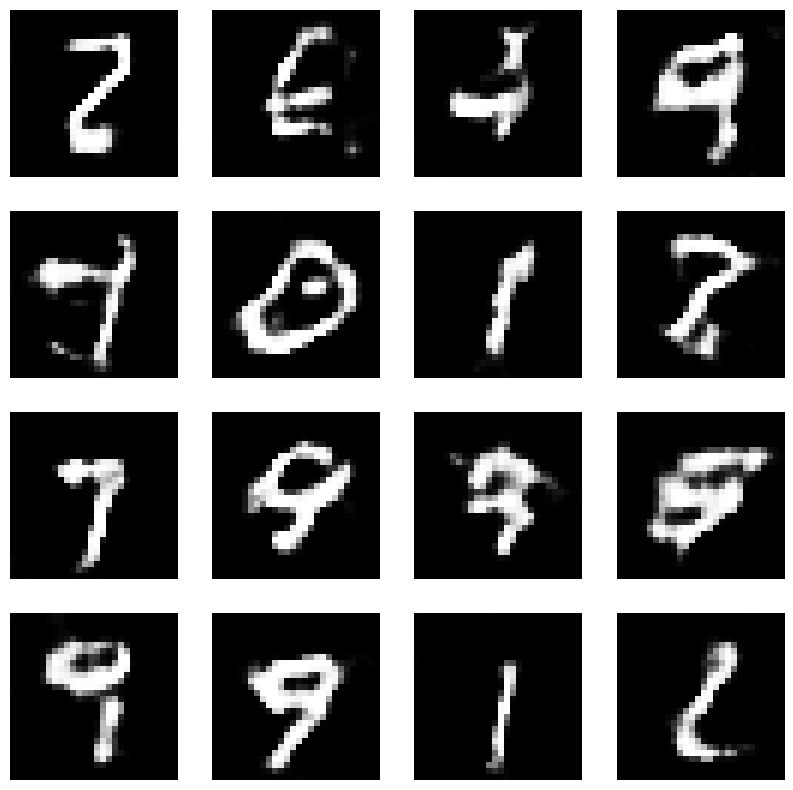

Epoch:  55


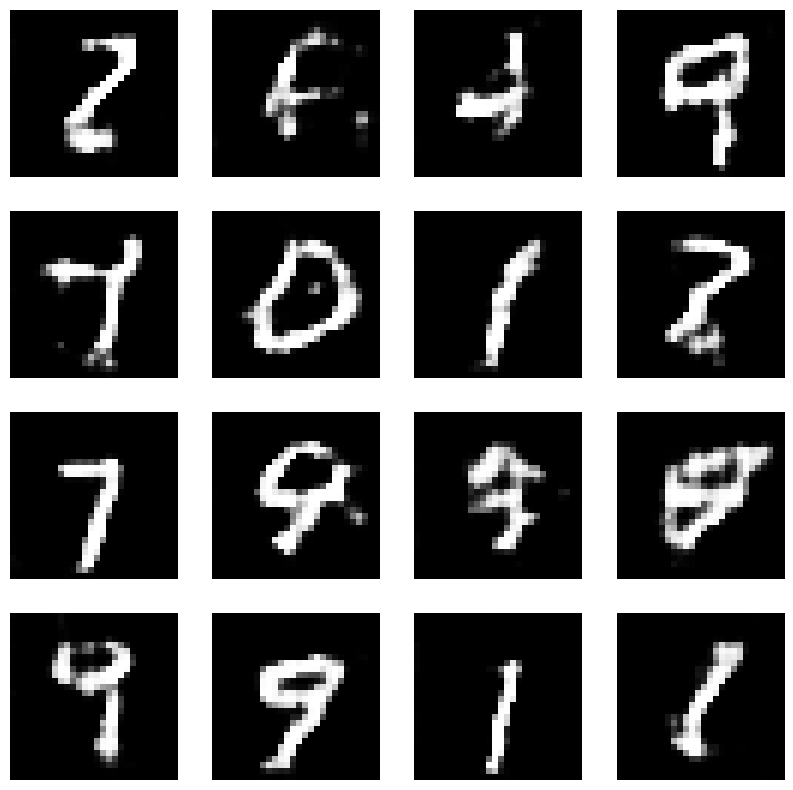

Epoch:  56


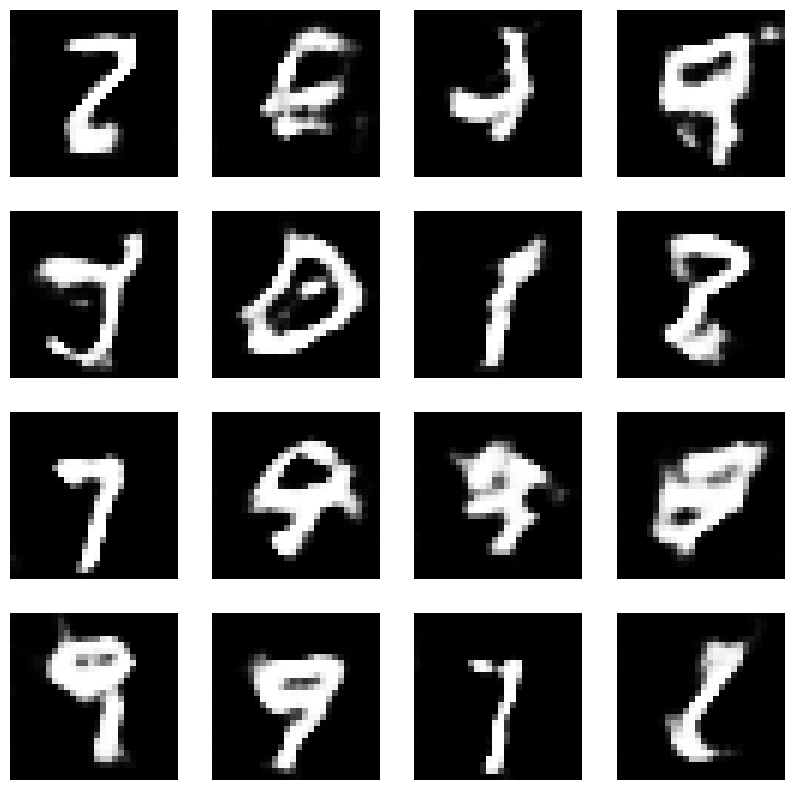

Epoch:  57


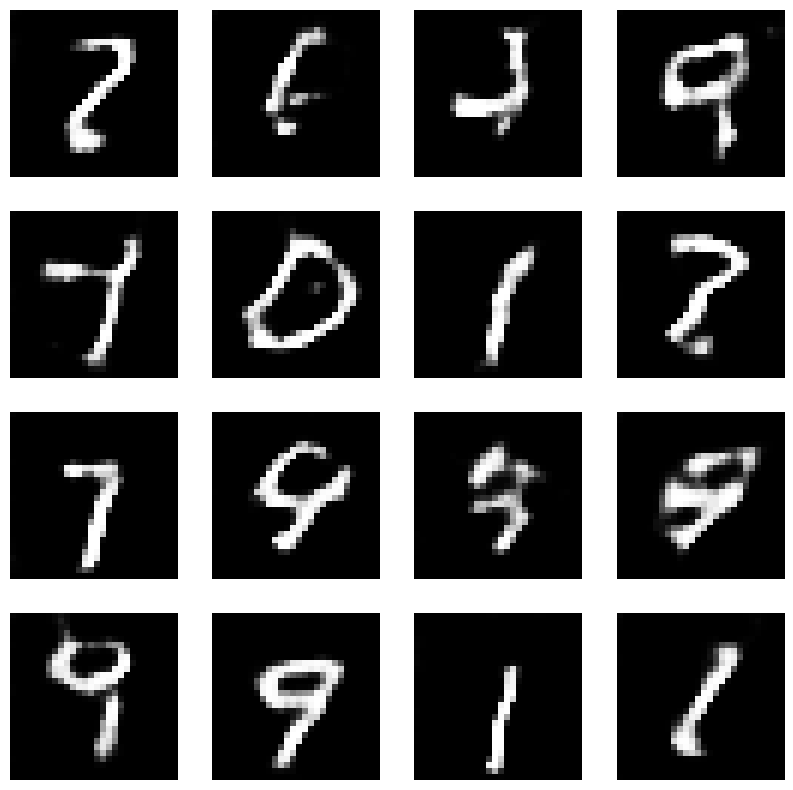

Epoch:  58


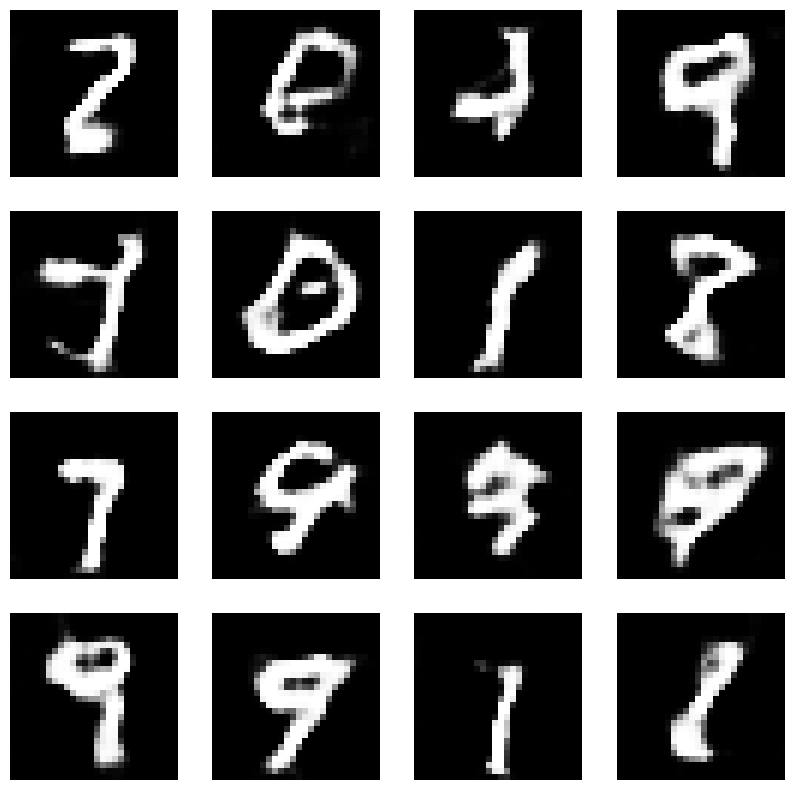

Epoch:  59


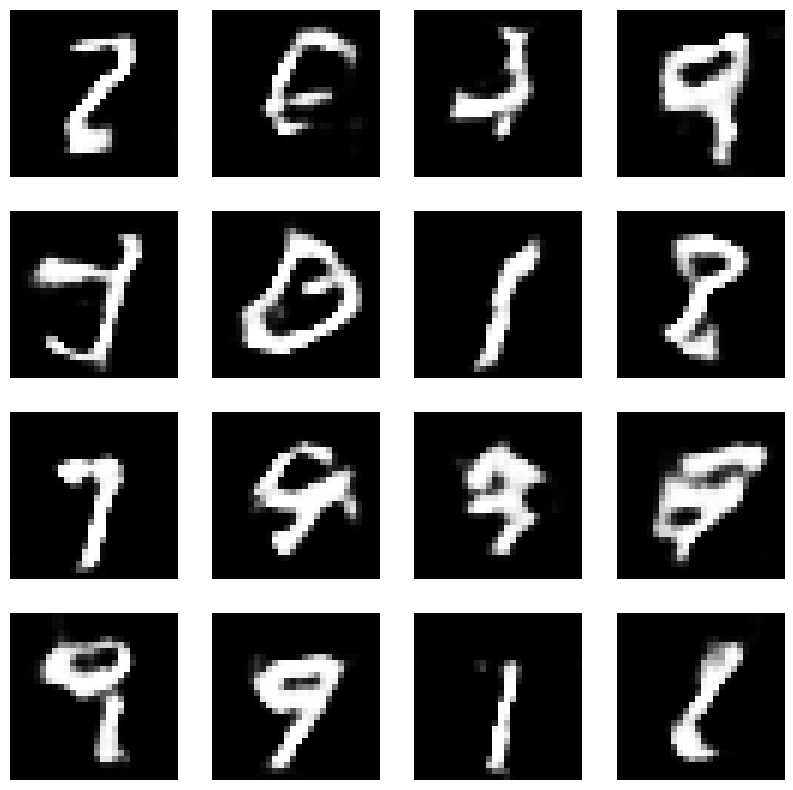

Epoch:  60


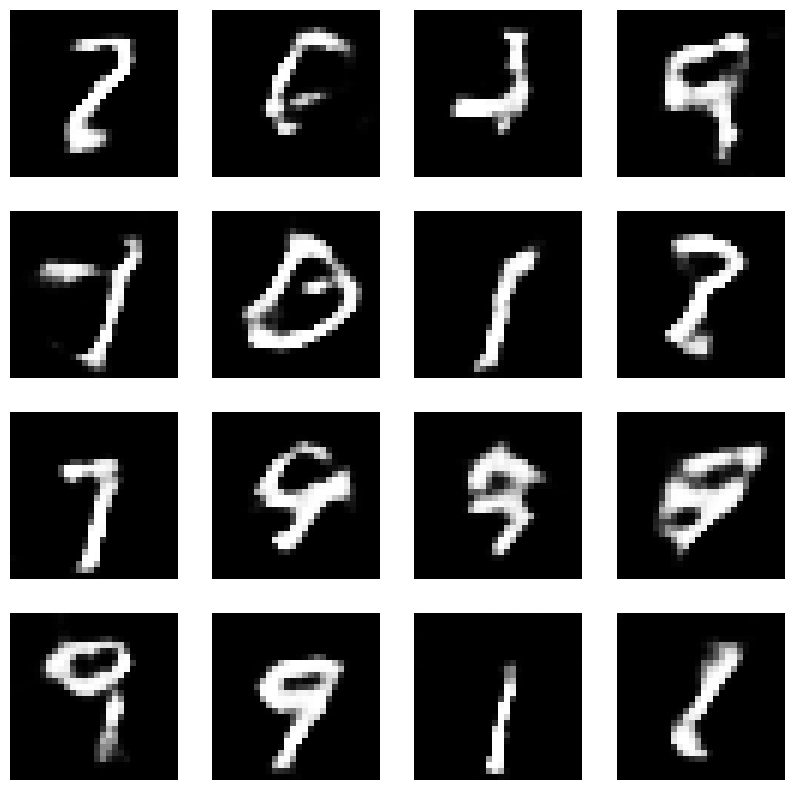

Epoch:  61


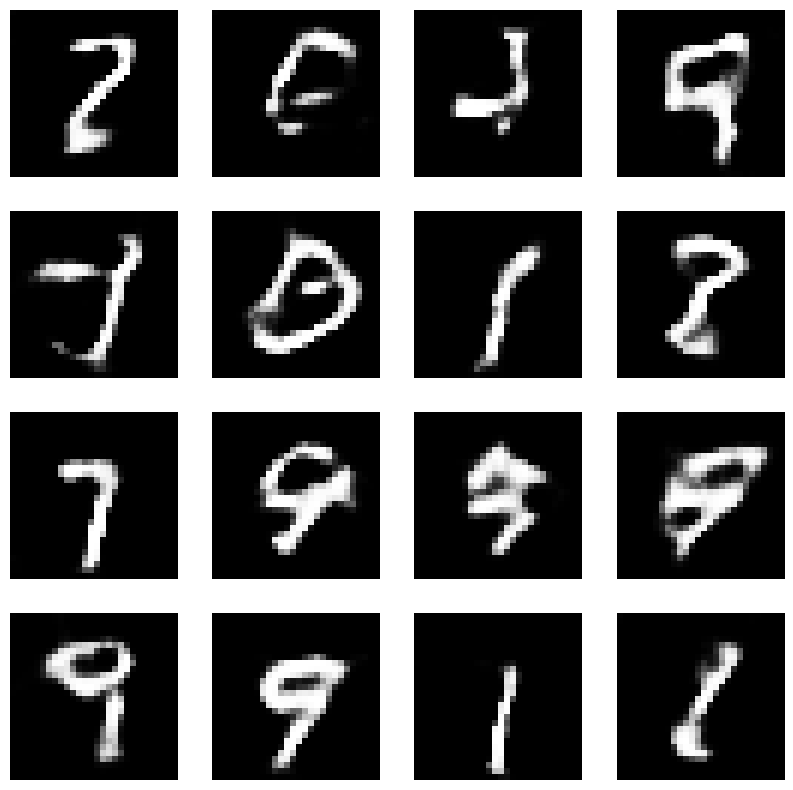

Epoch:  62


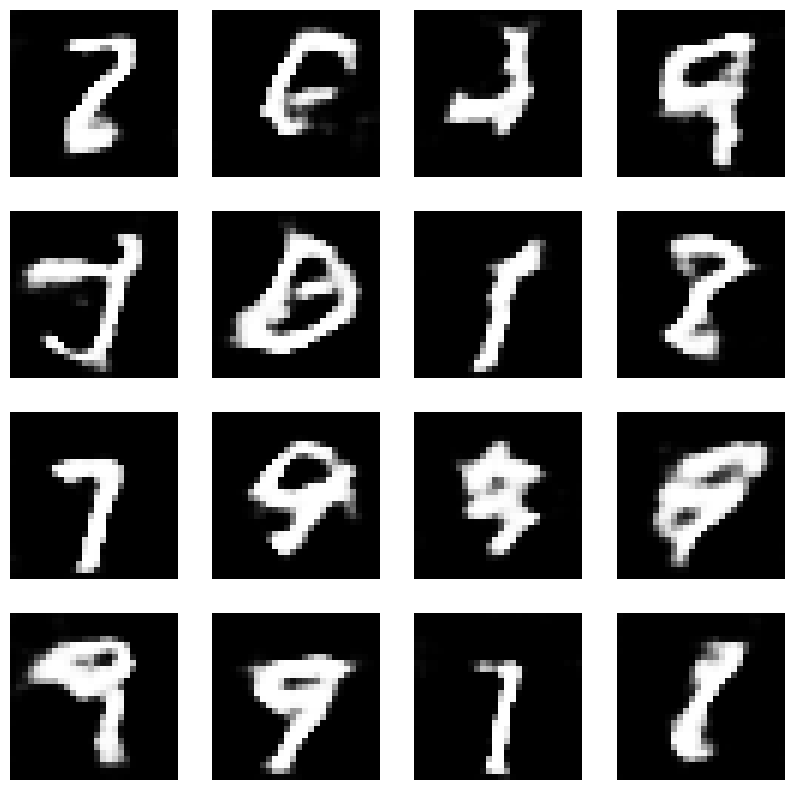

Epoch:  63


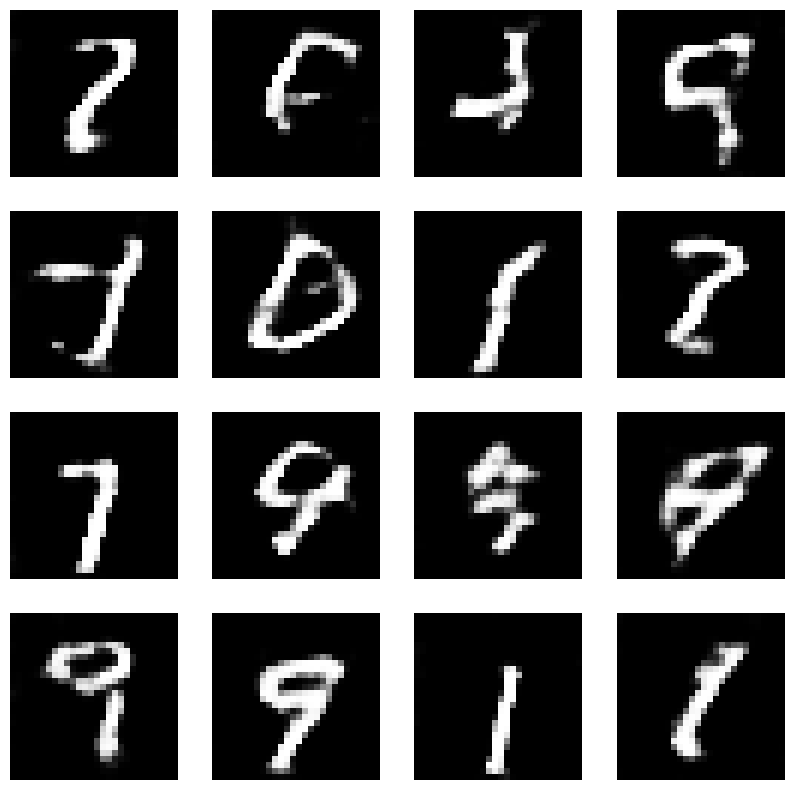

Epoch:  64


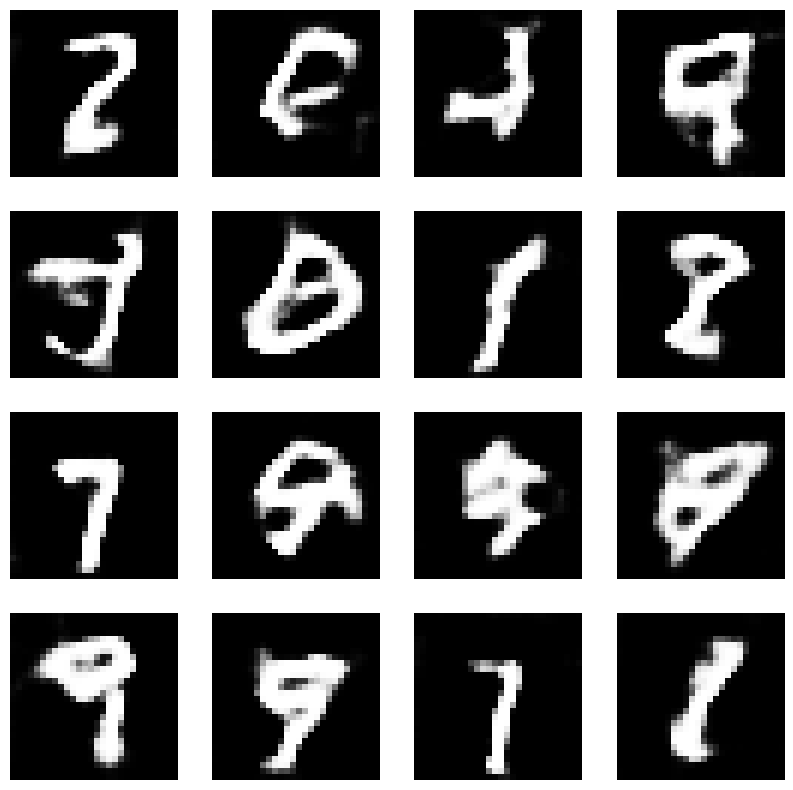

Epoch:  65


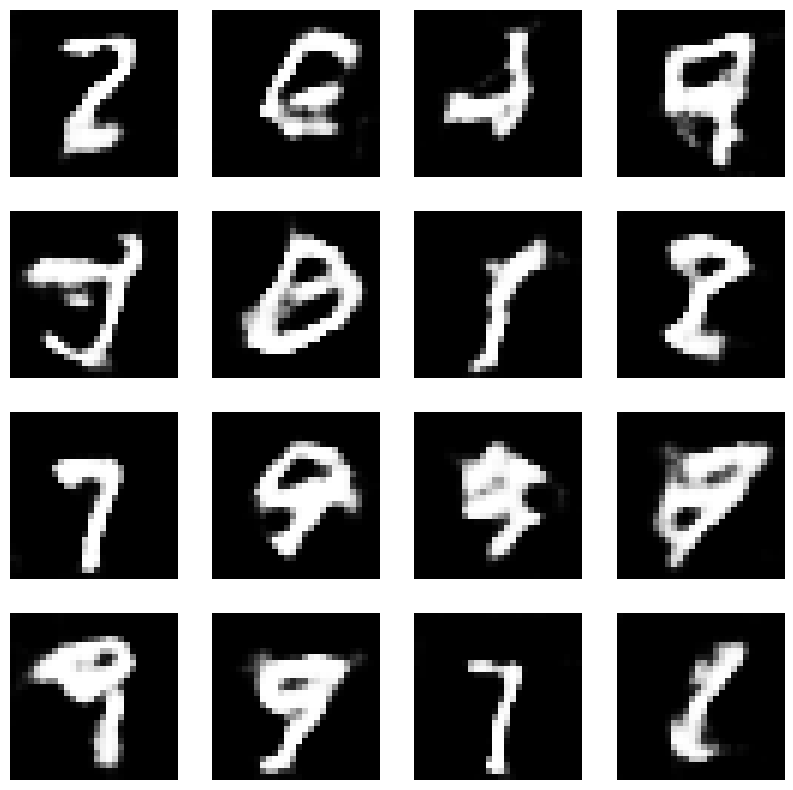

Epoch:  66


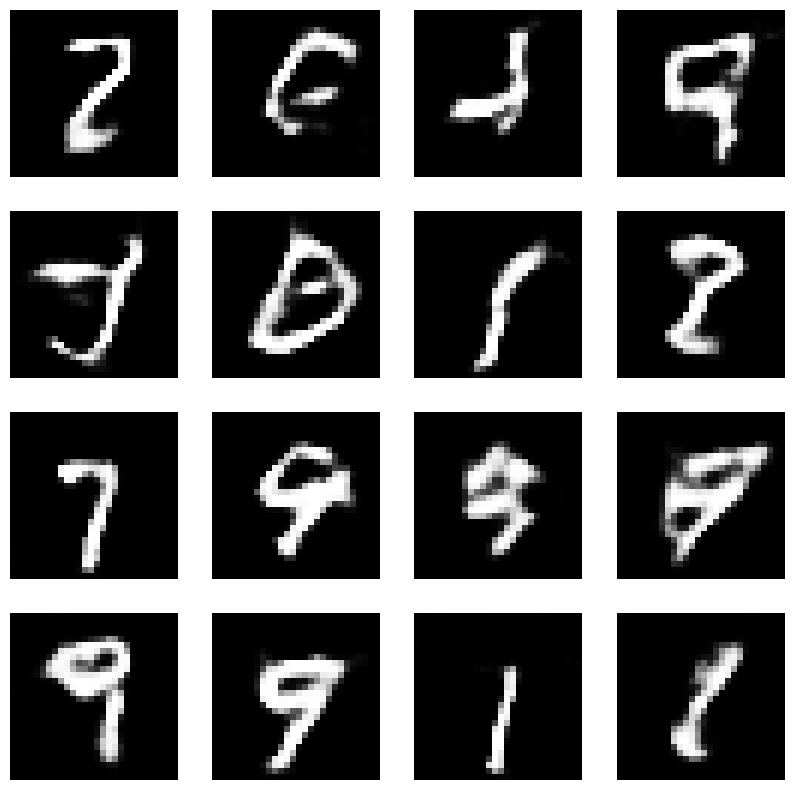

Epoch:  67


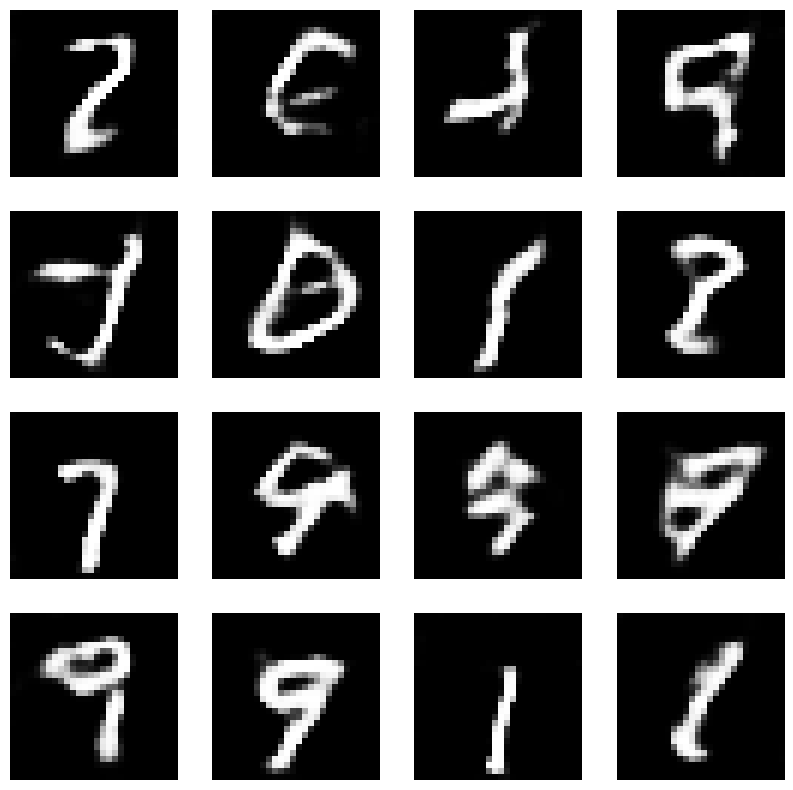

Epoch:  68


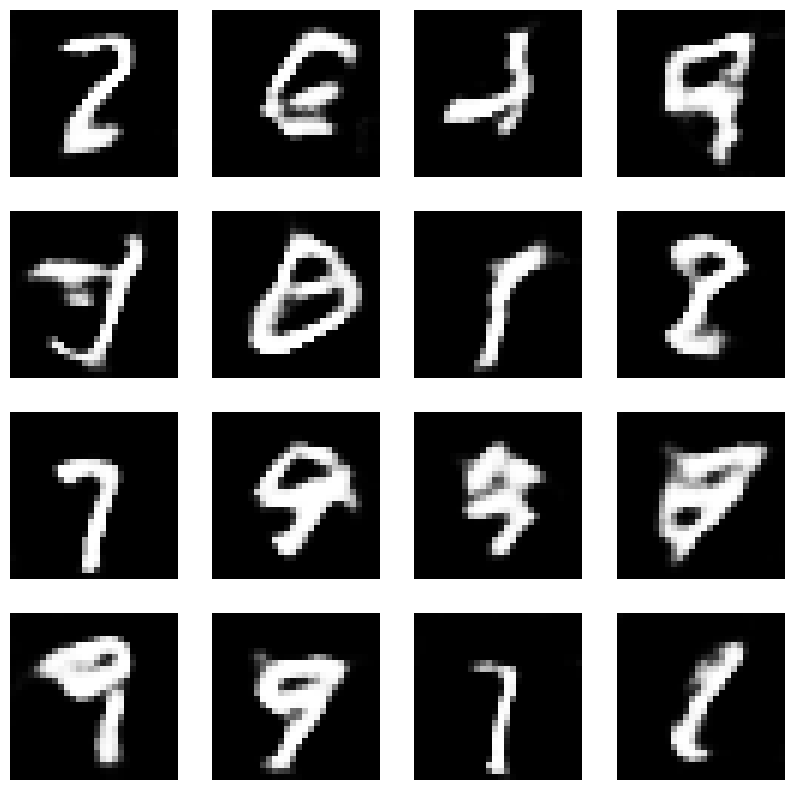

Epoch:  69


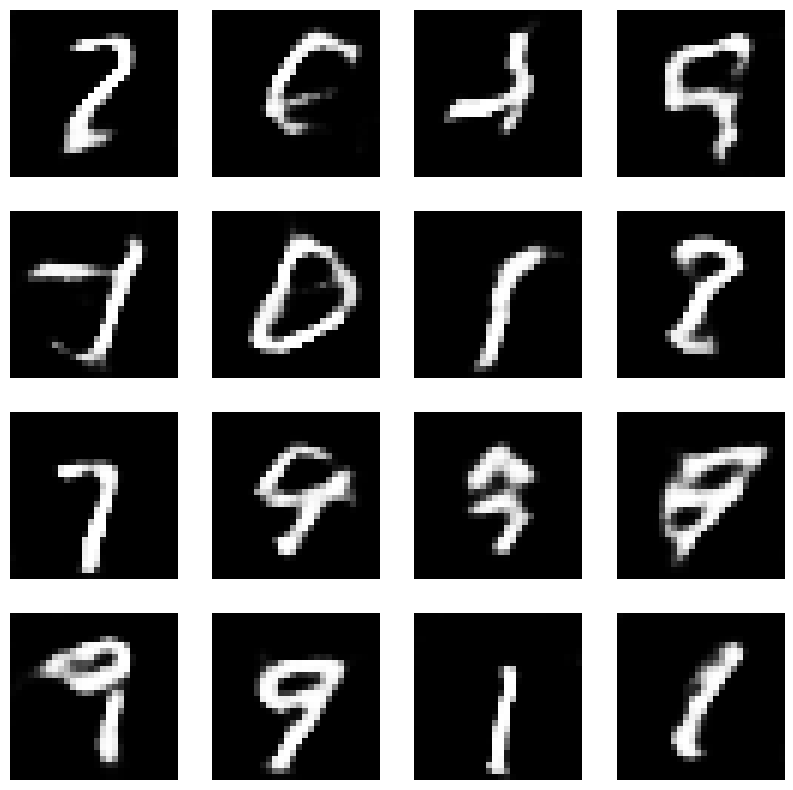

Epoch:  70


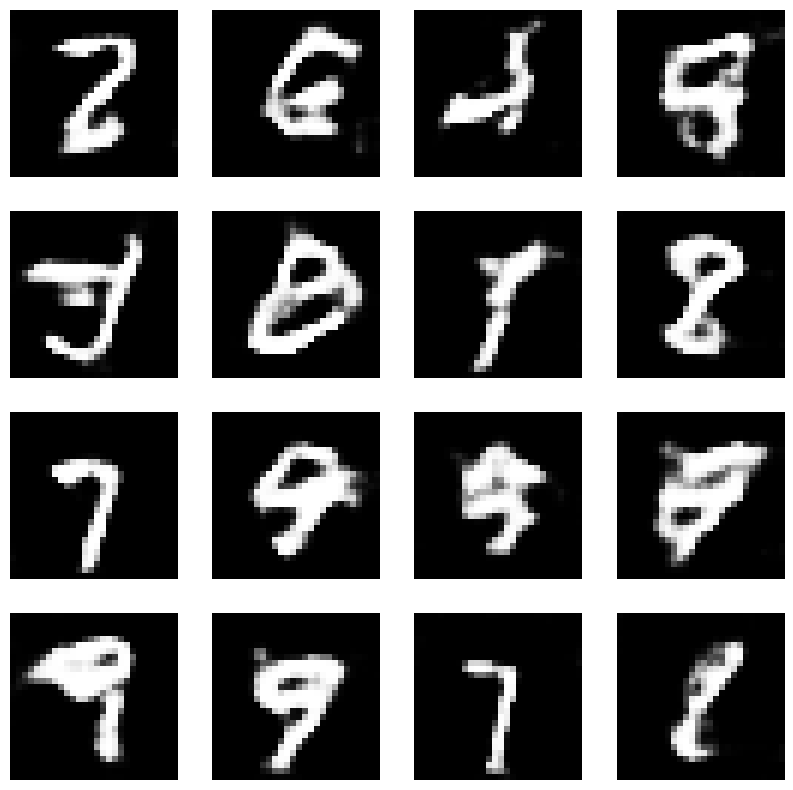

Epoch:  71


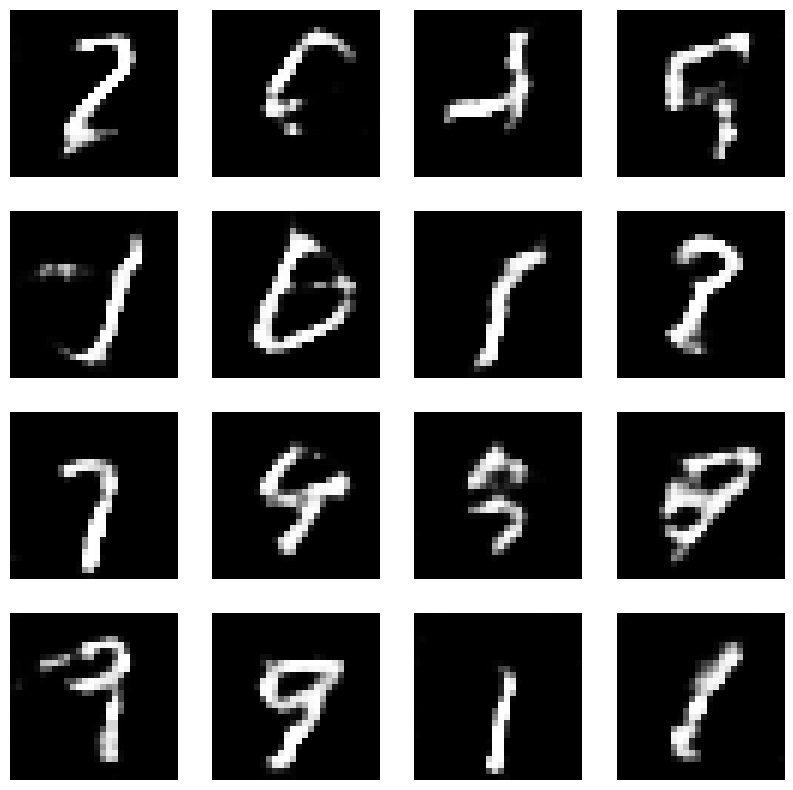

Epoch:  72


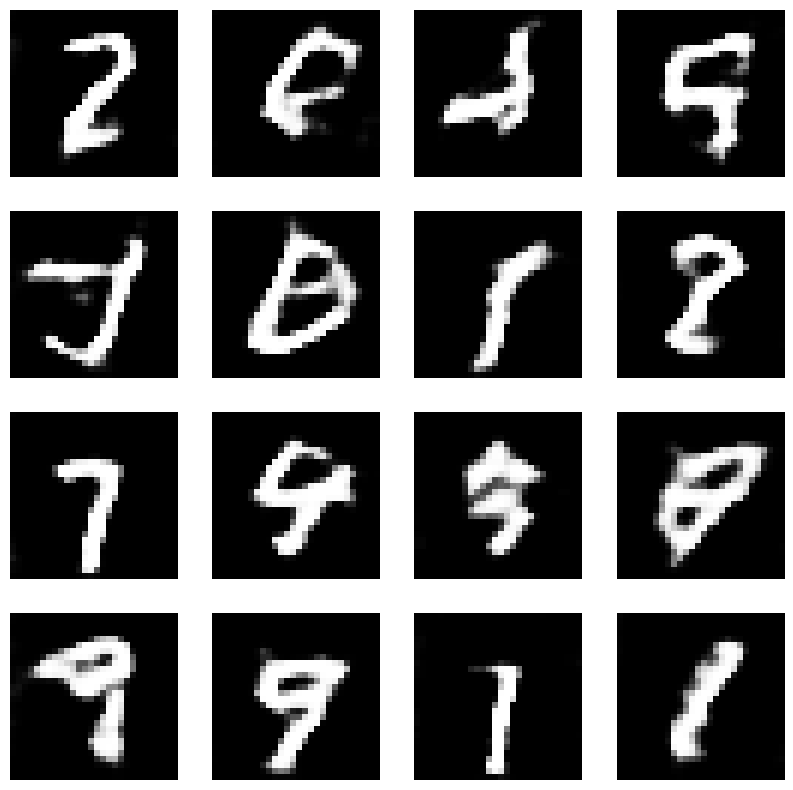

Epoch:  73


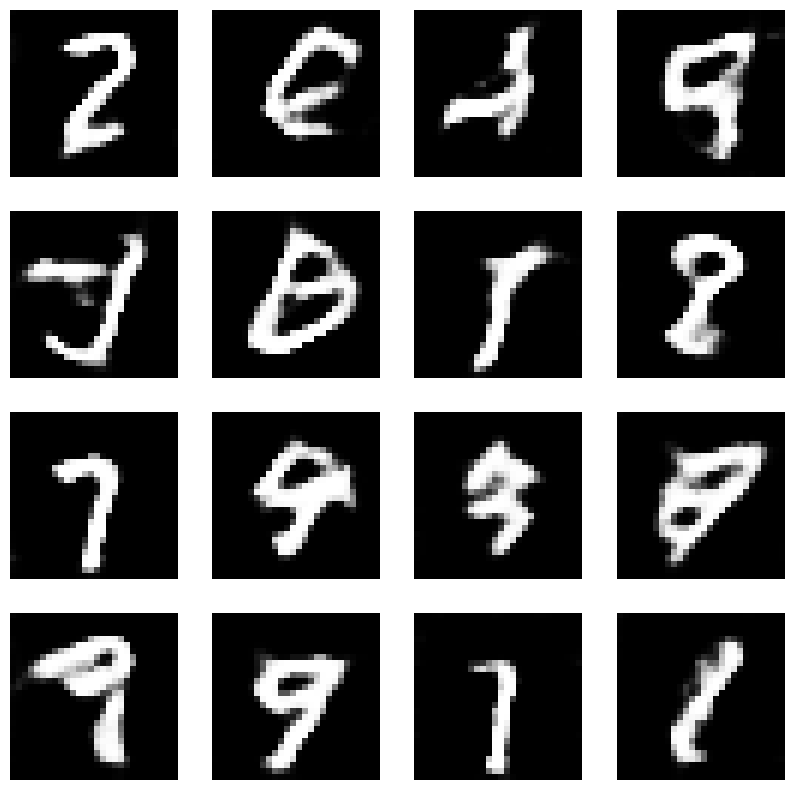

Epoch:  74


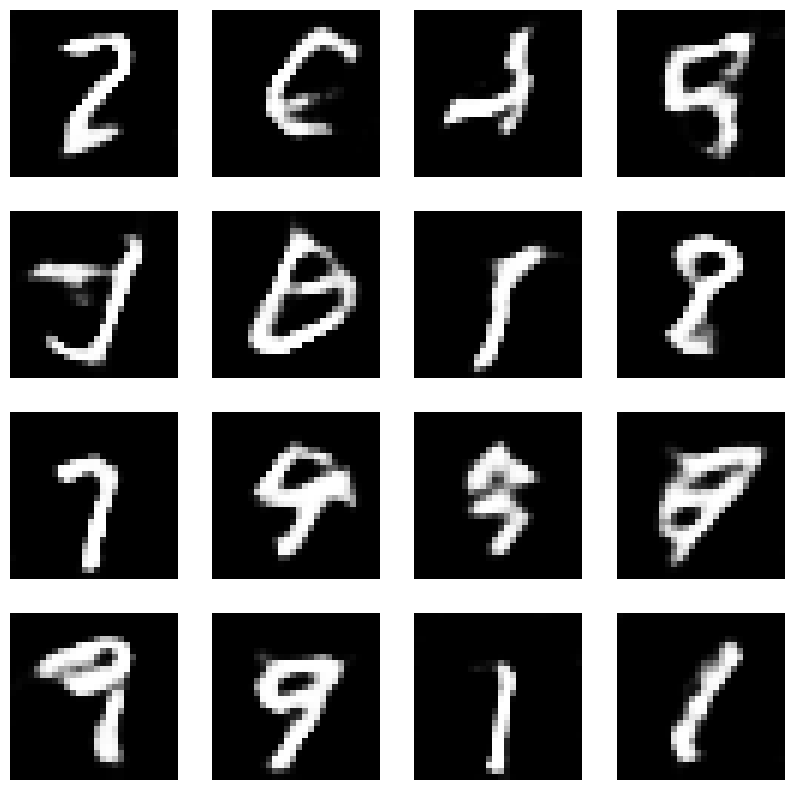

Epoch:  75


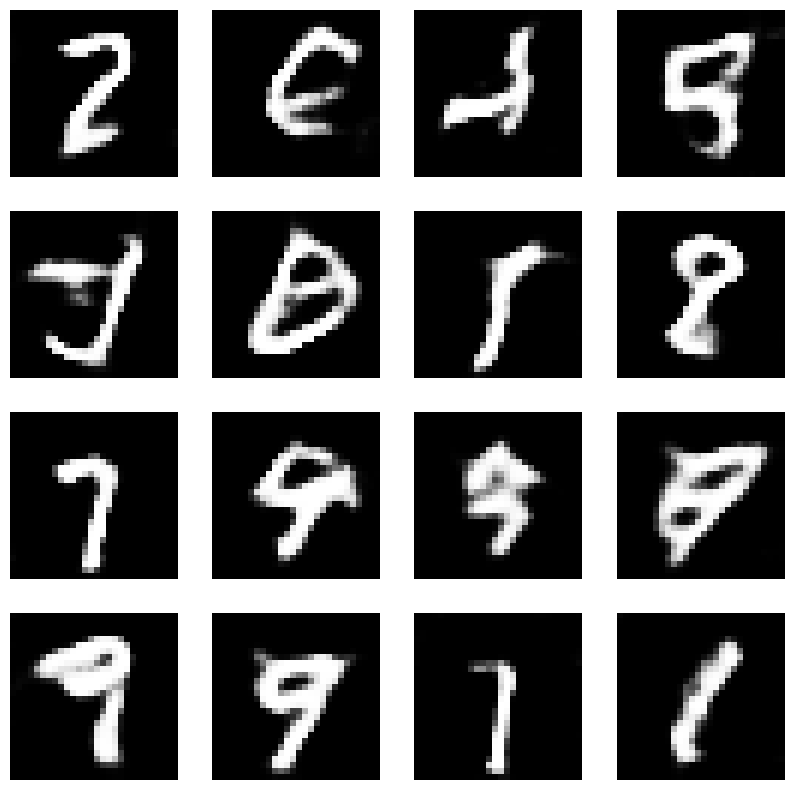

Epoch:  76


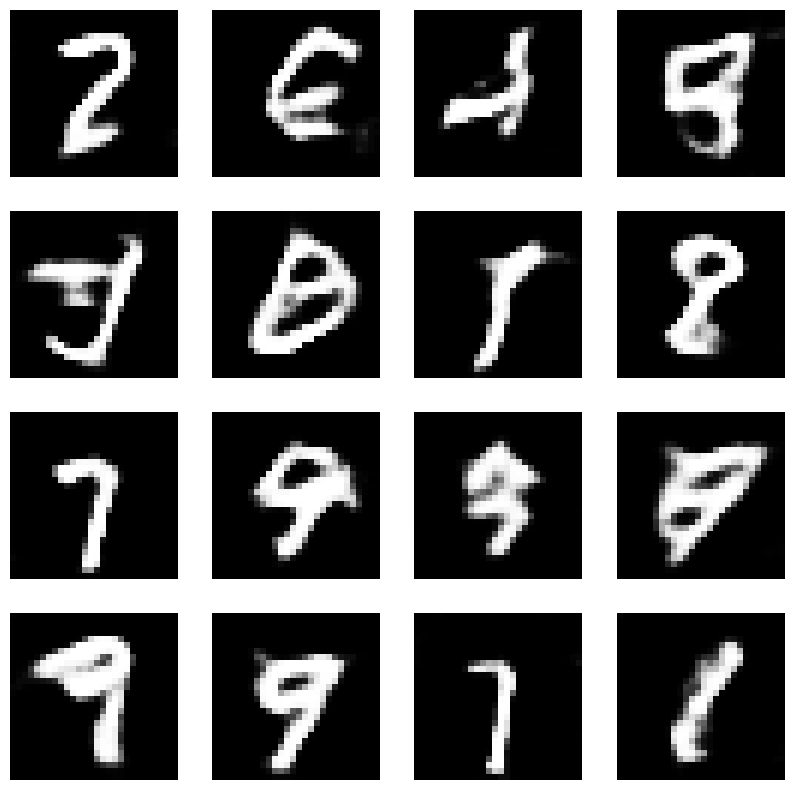

Epoch:  77


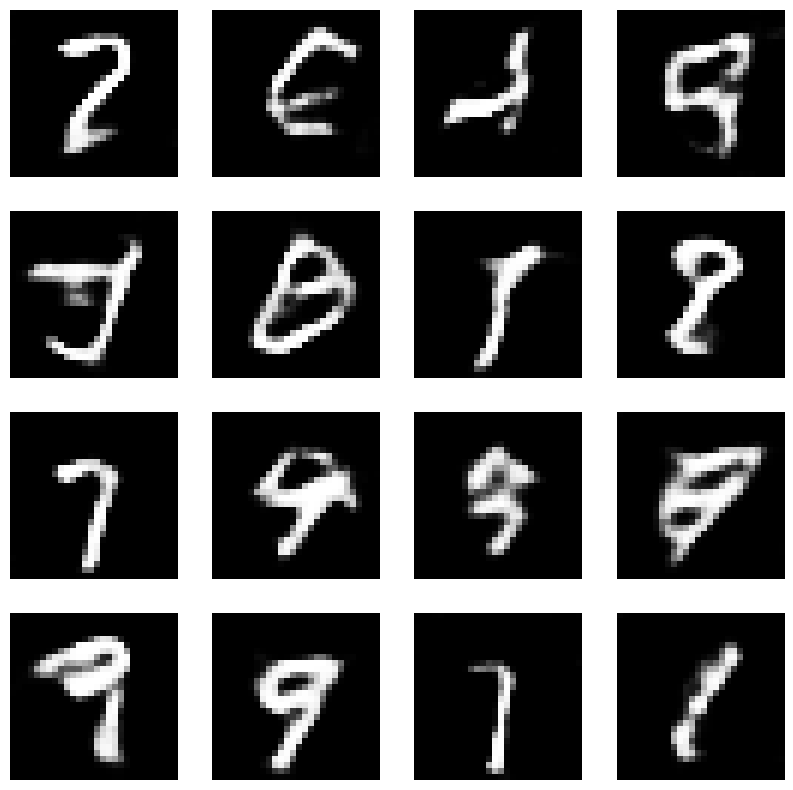

Epoch:  78


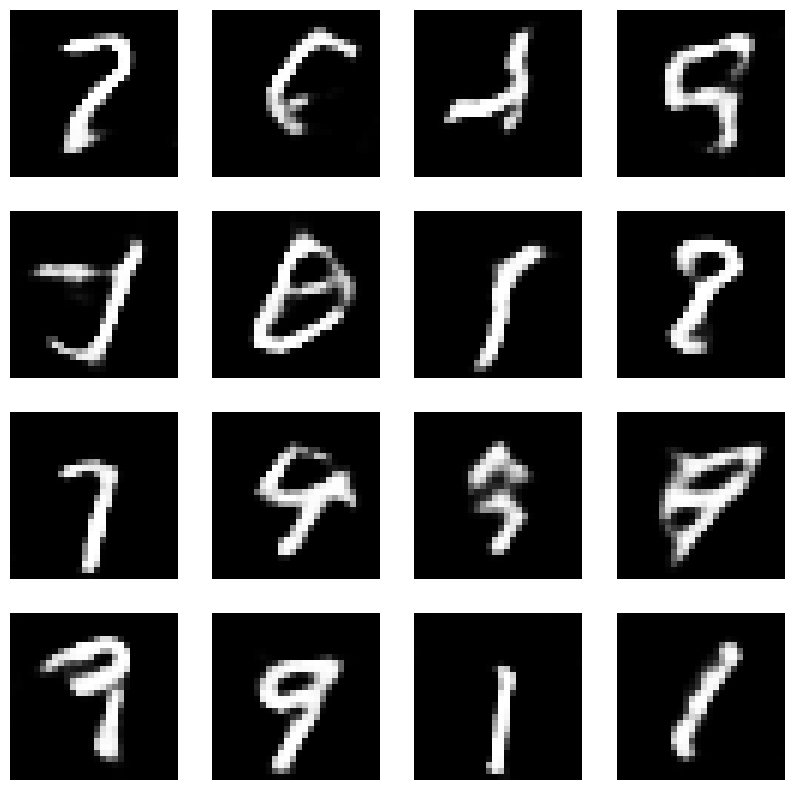

Epoch:  79


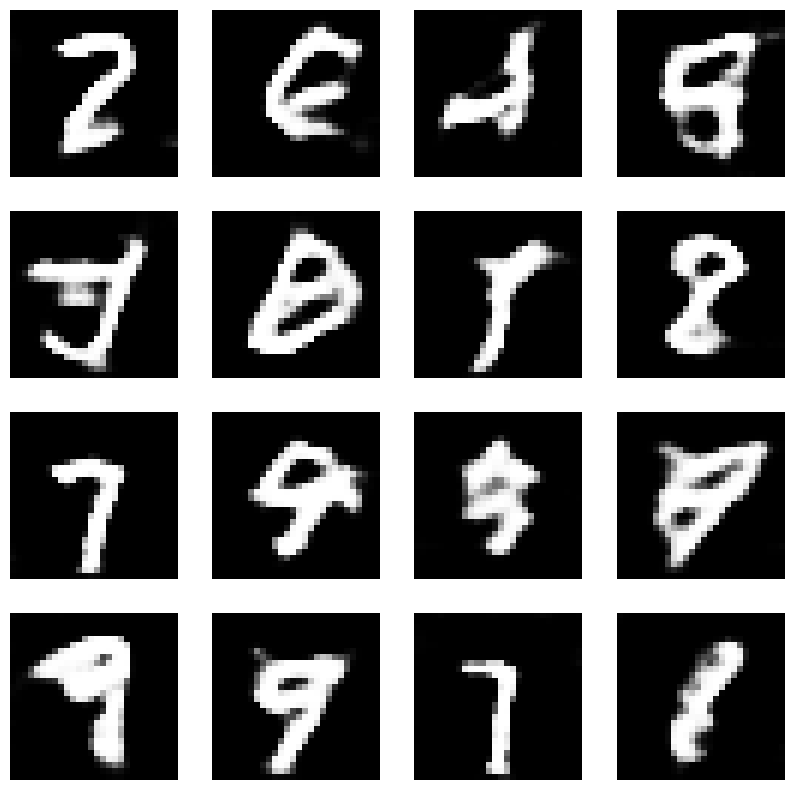

Epoch:  80


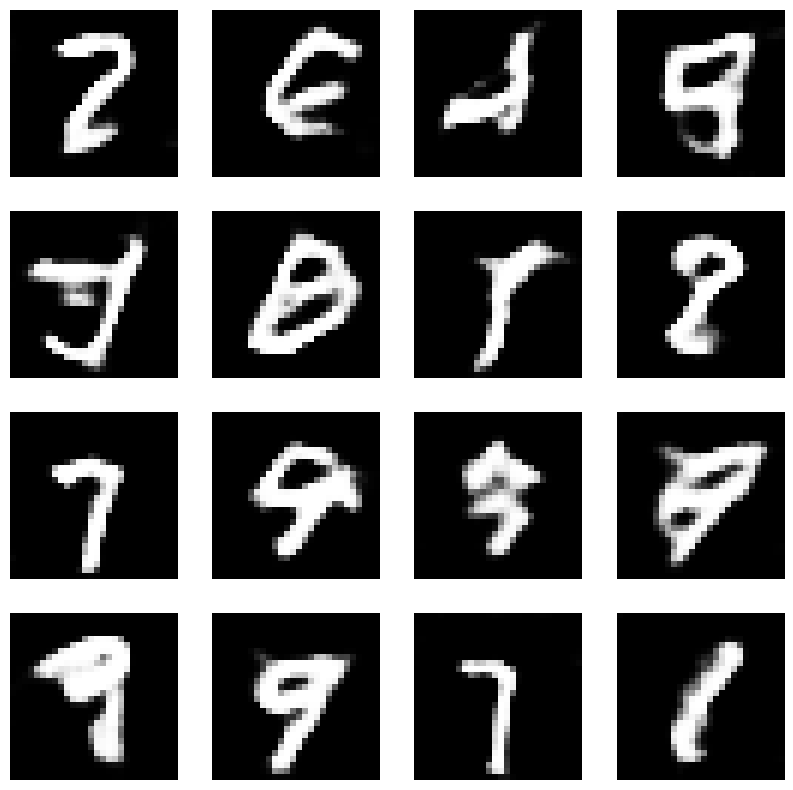

Epoch:  81


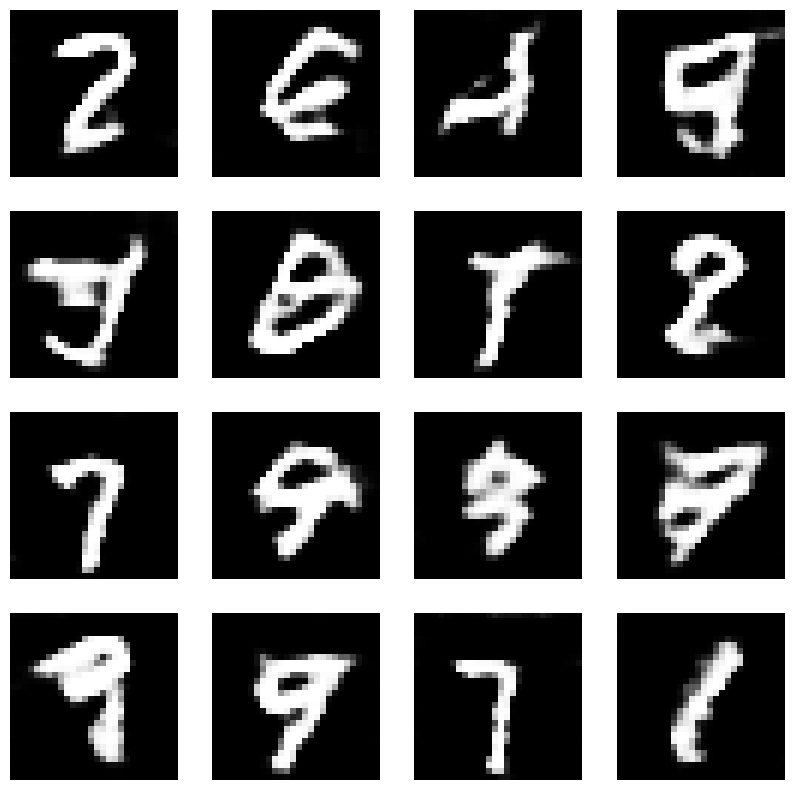

Epoch:  82


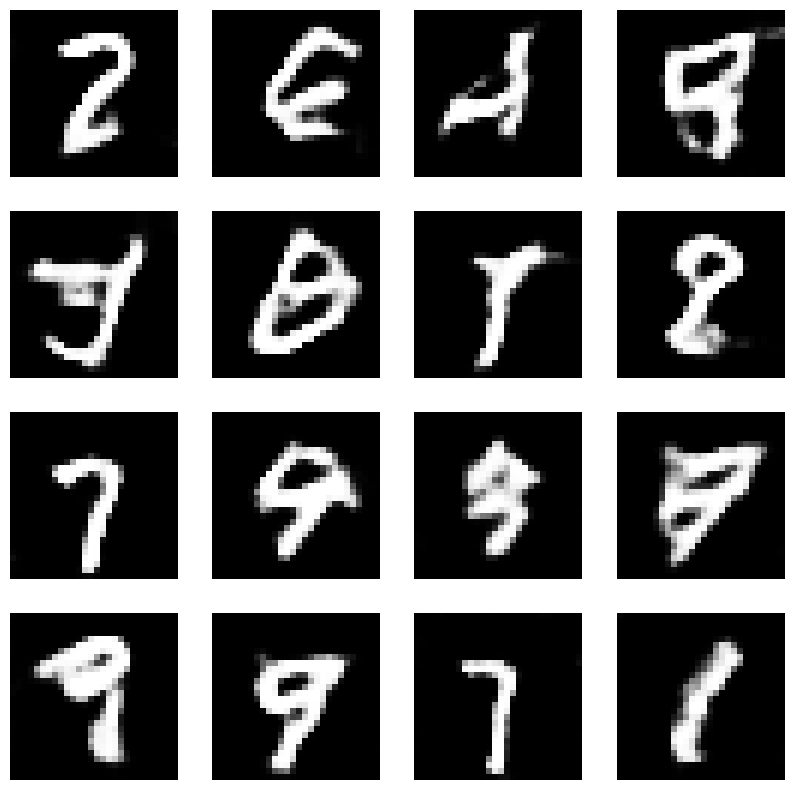

Epoch:  83


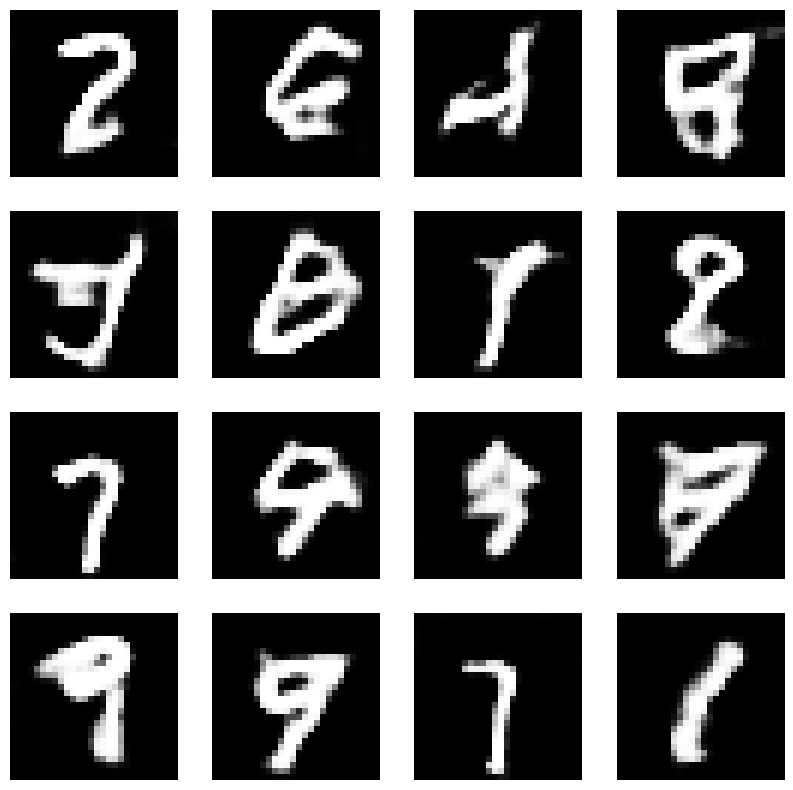

Epoch:  84


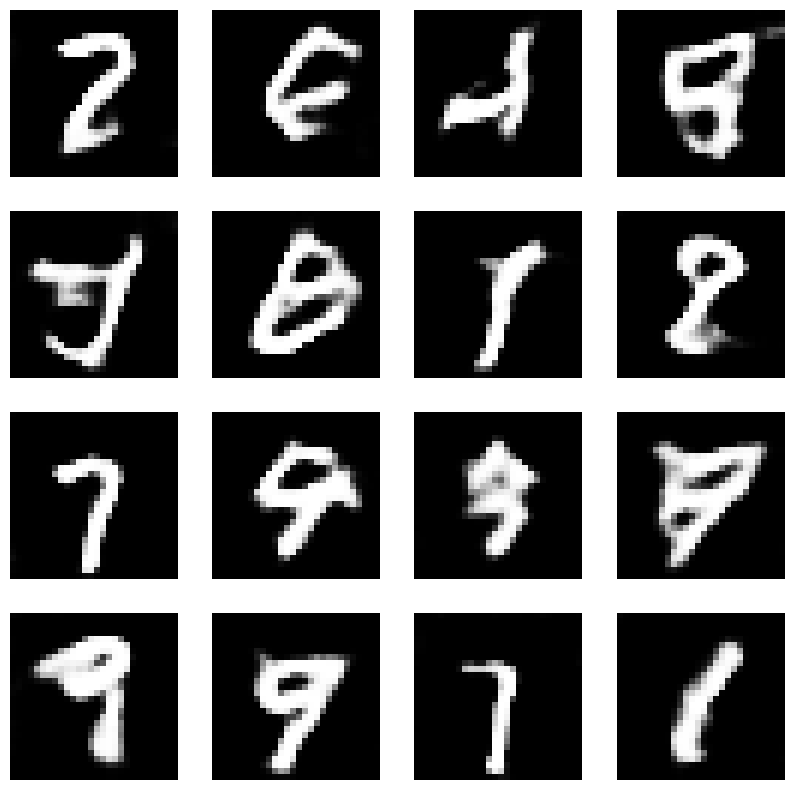

Epoch:  85


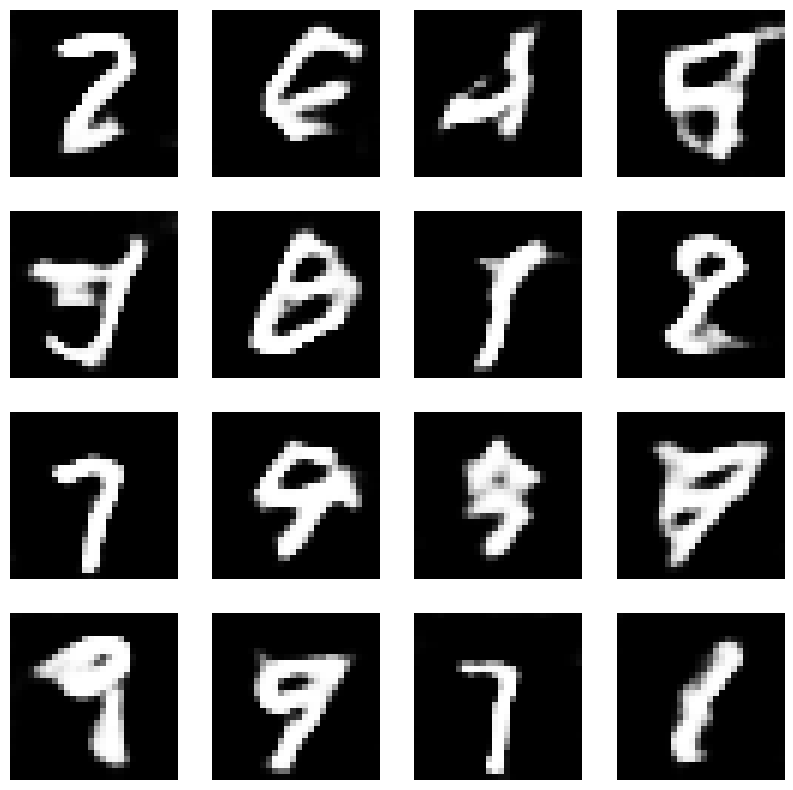

Epoch:  86


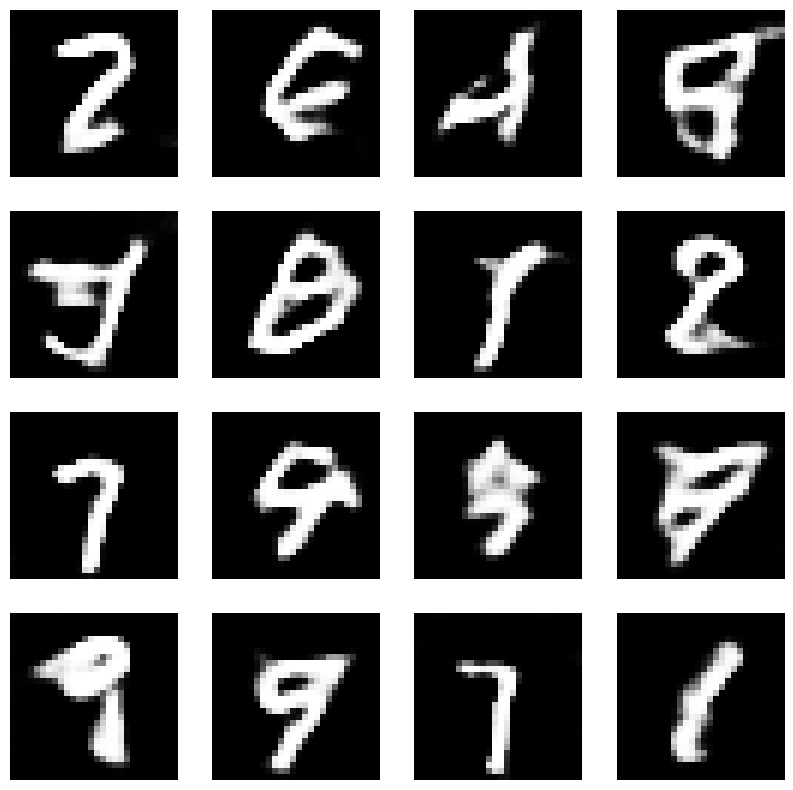

Epoch:  87


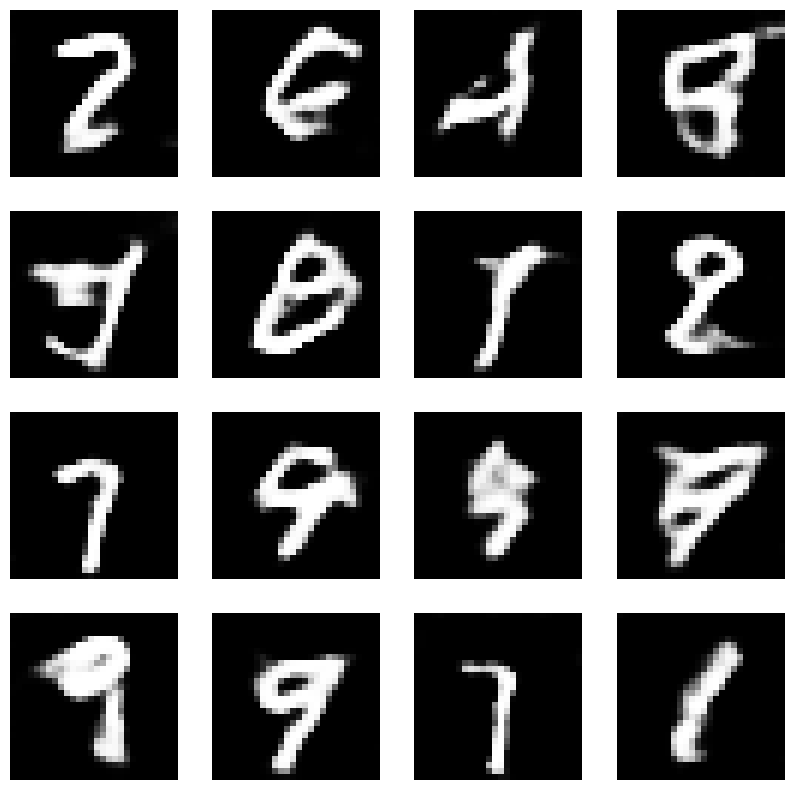

Epoch:  88


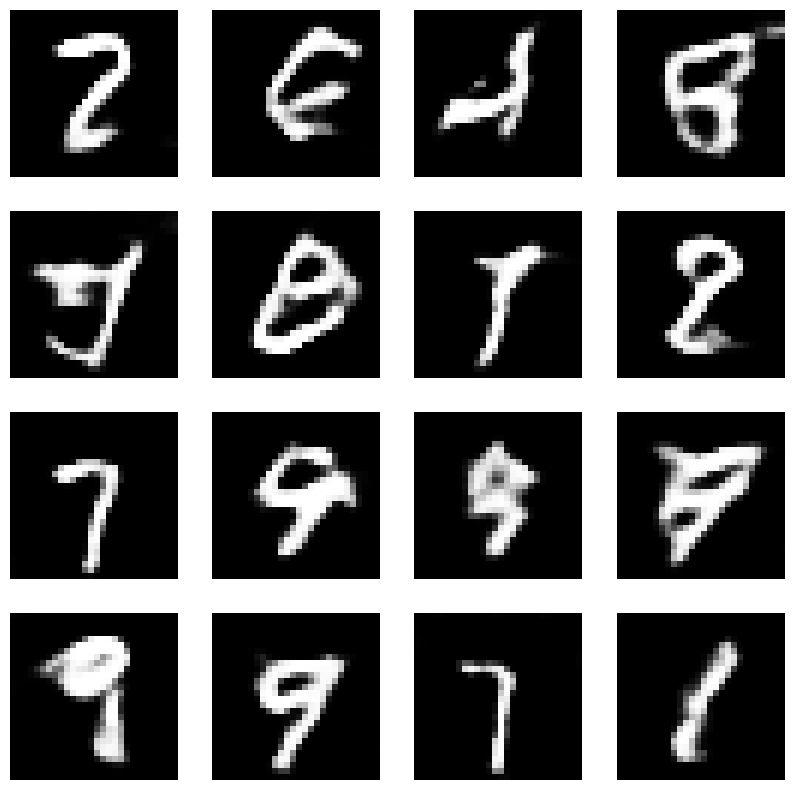

Epoch:  89


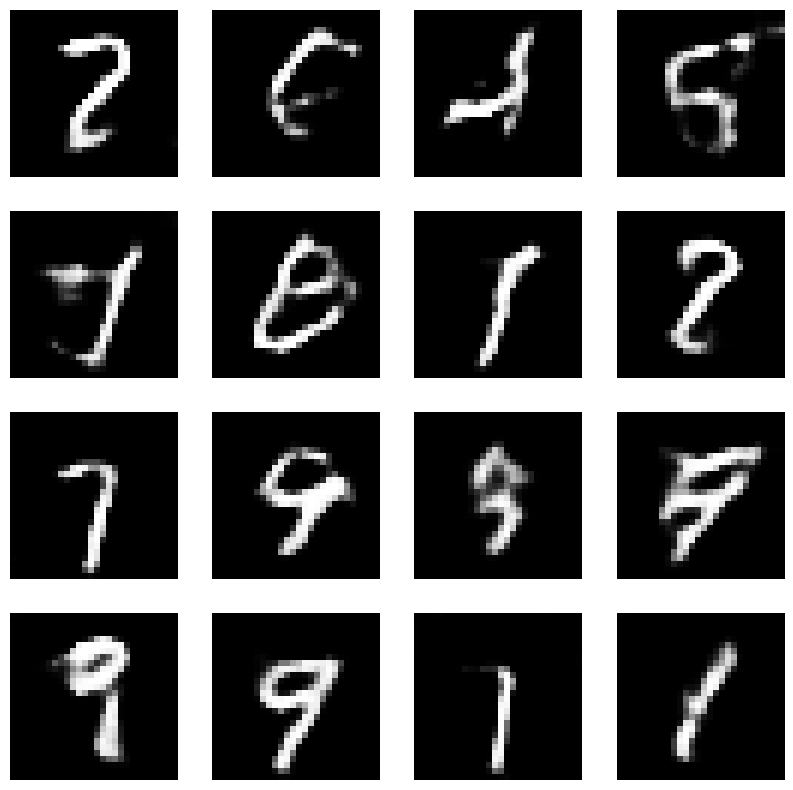

Epoch:  90


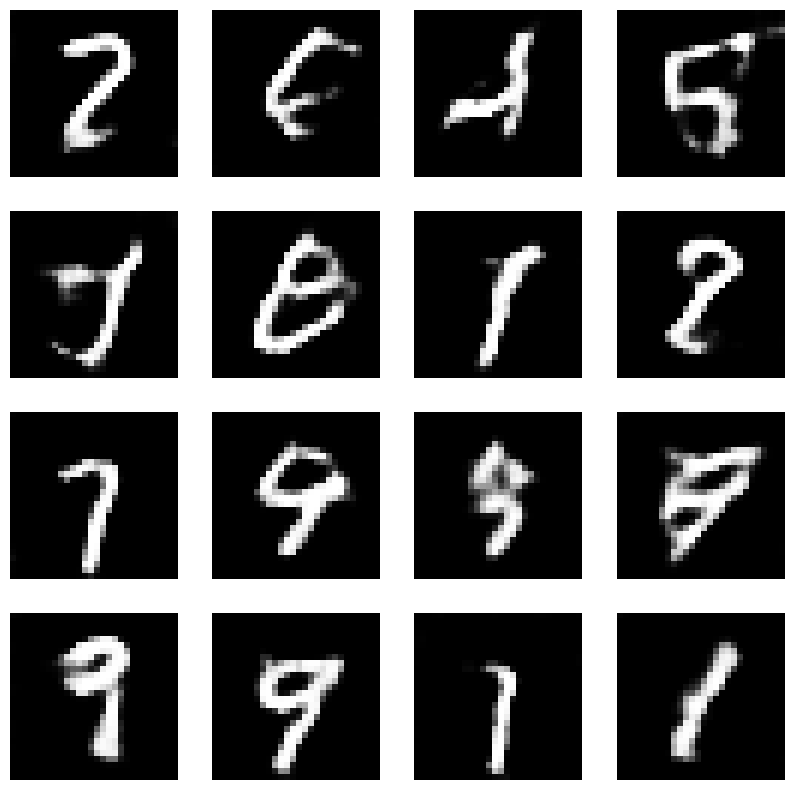

Epoch:  91


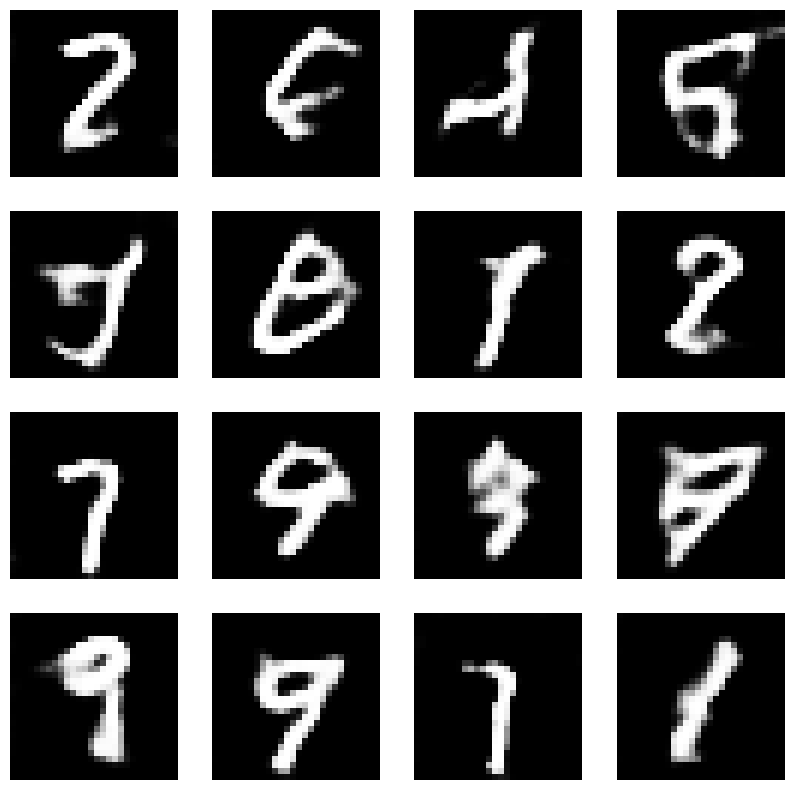

Epoch:  92


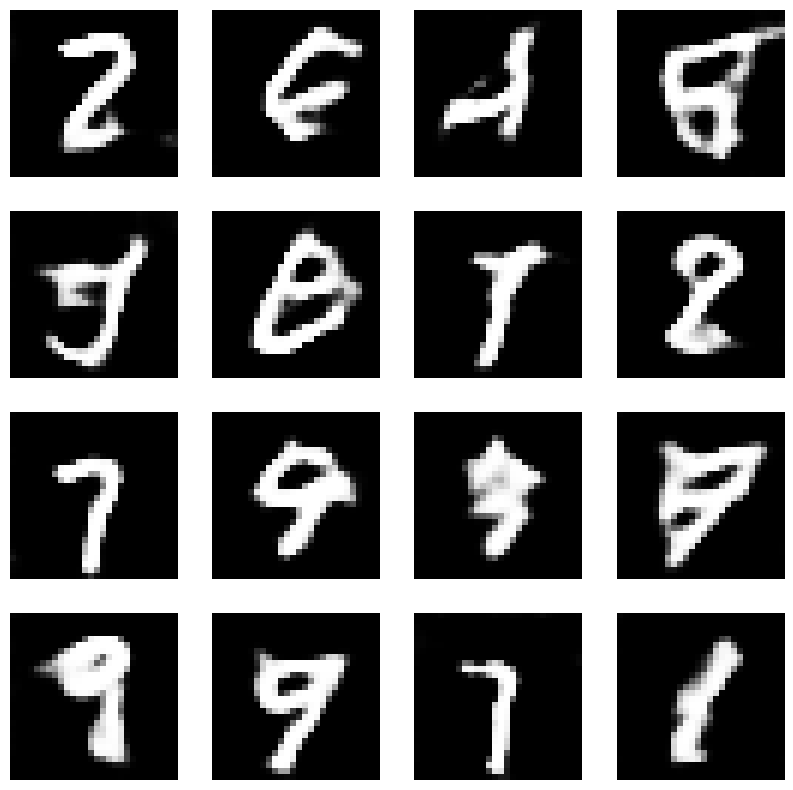

Epoch:  93


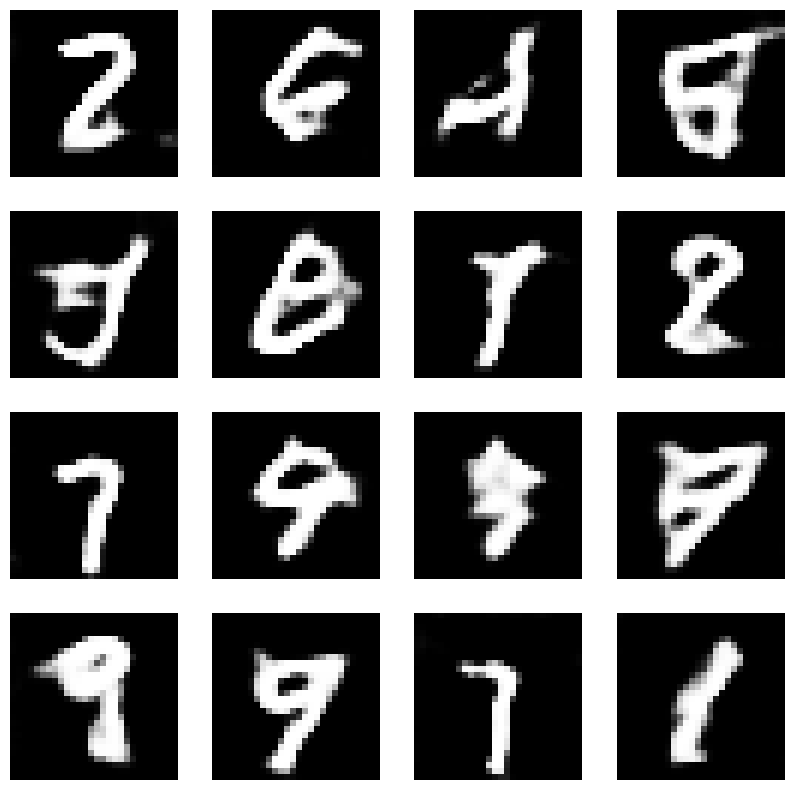

Epoch:  94


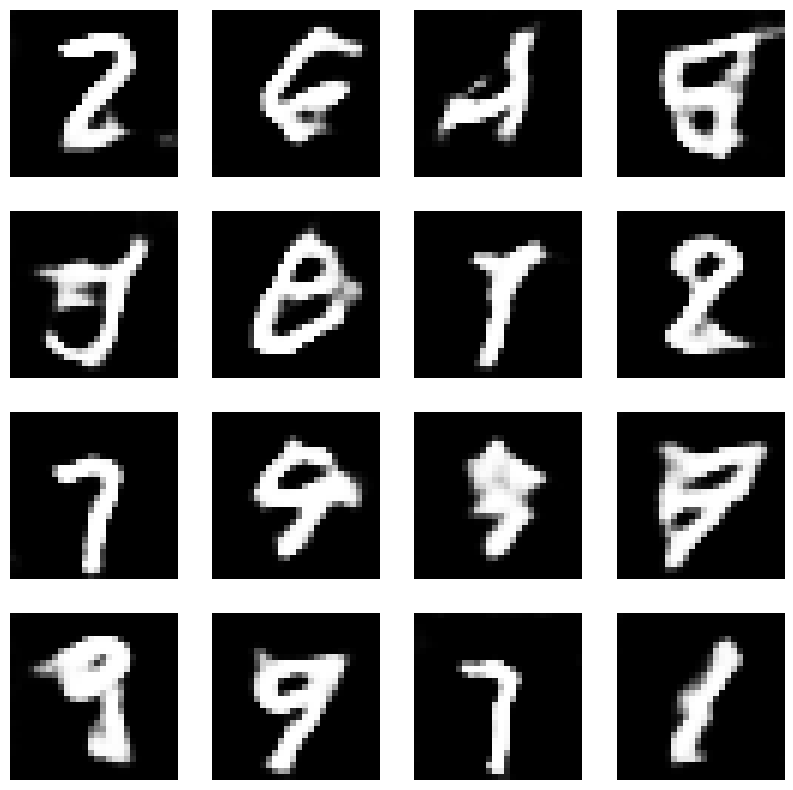

Epoch:  95


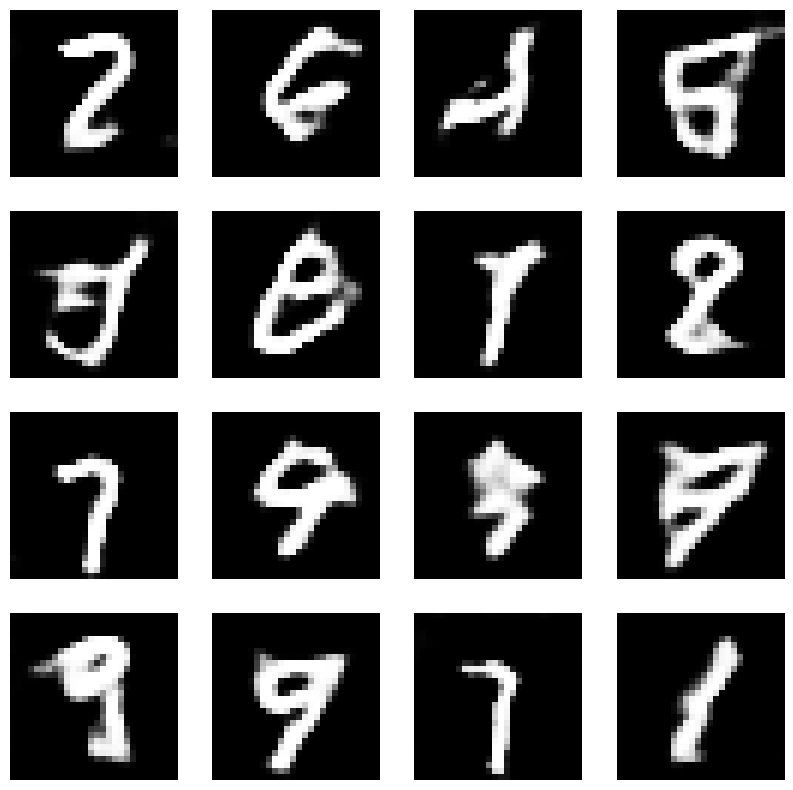

Epoch:  96


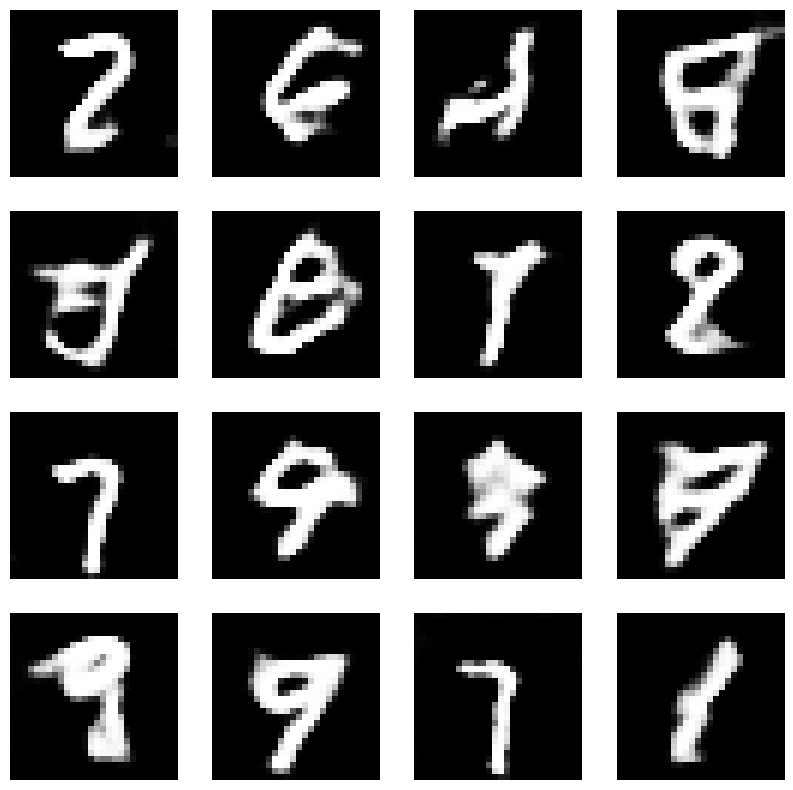

Epoch:  97


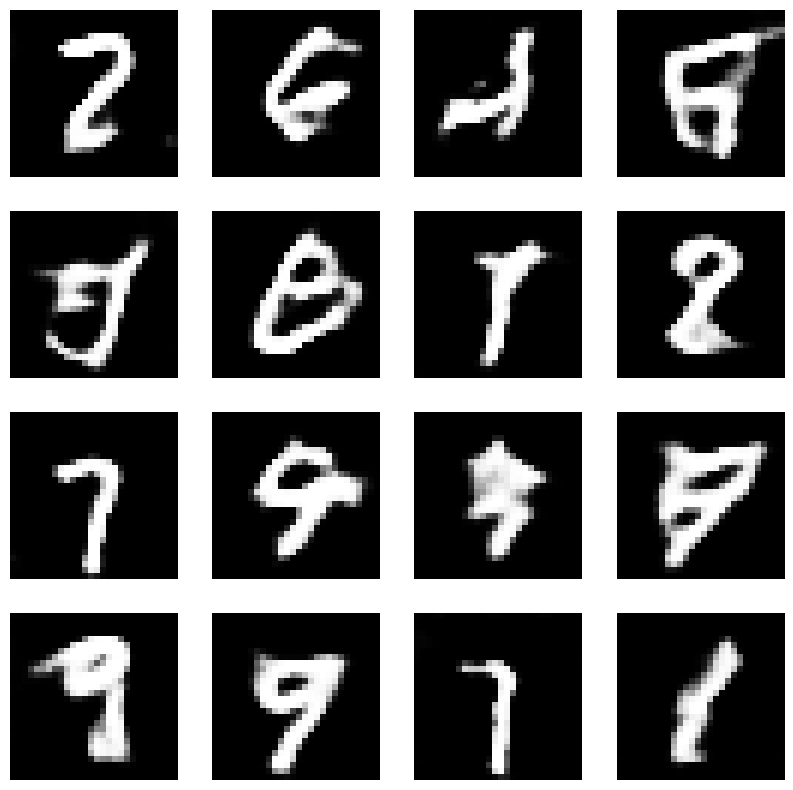

Epoch:  98


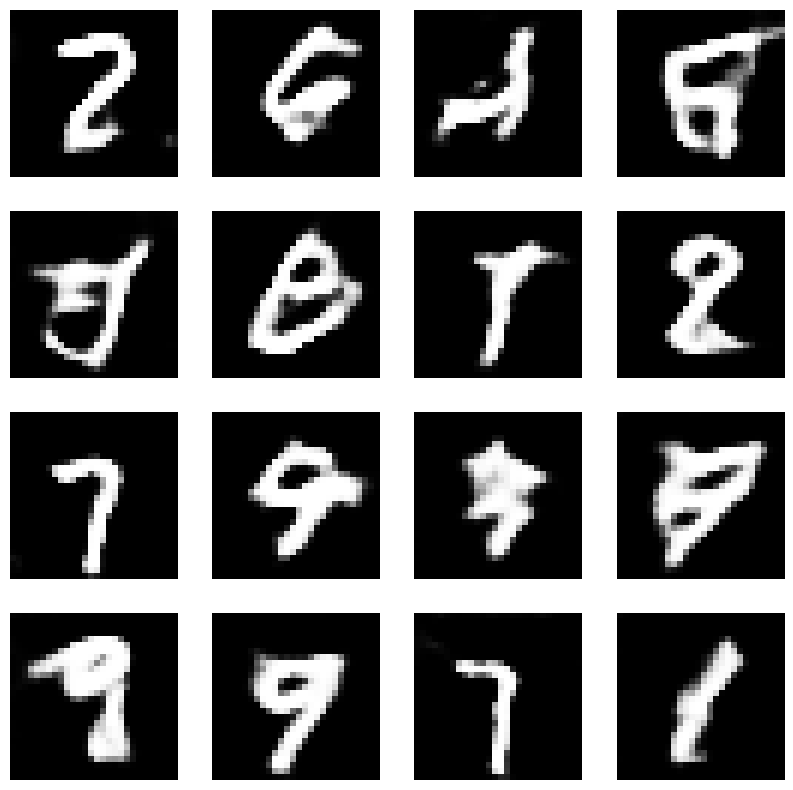

Epoch:  99


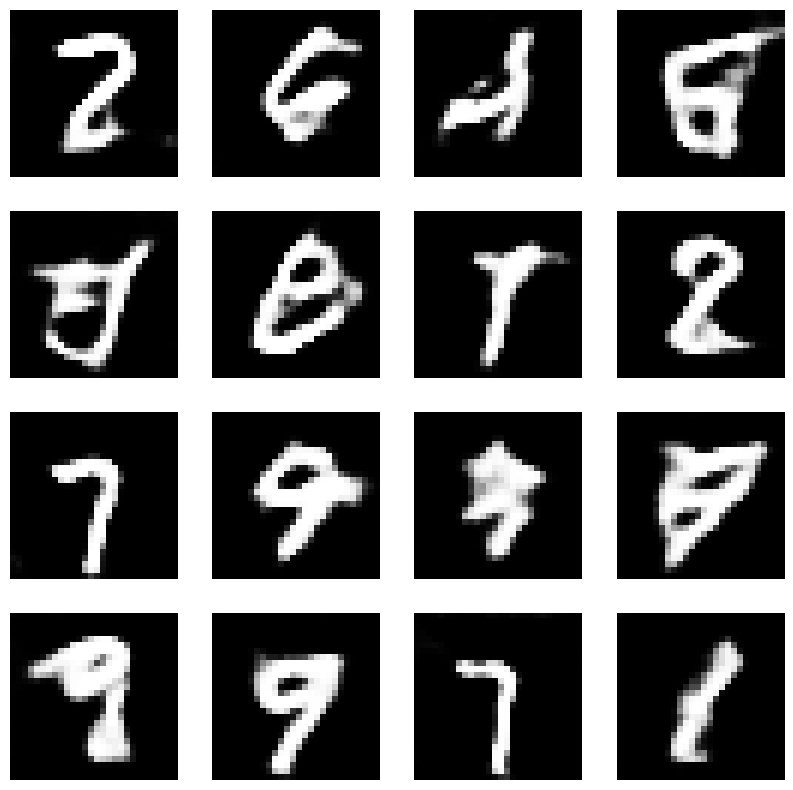

Epoch:  100


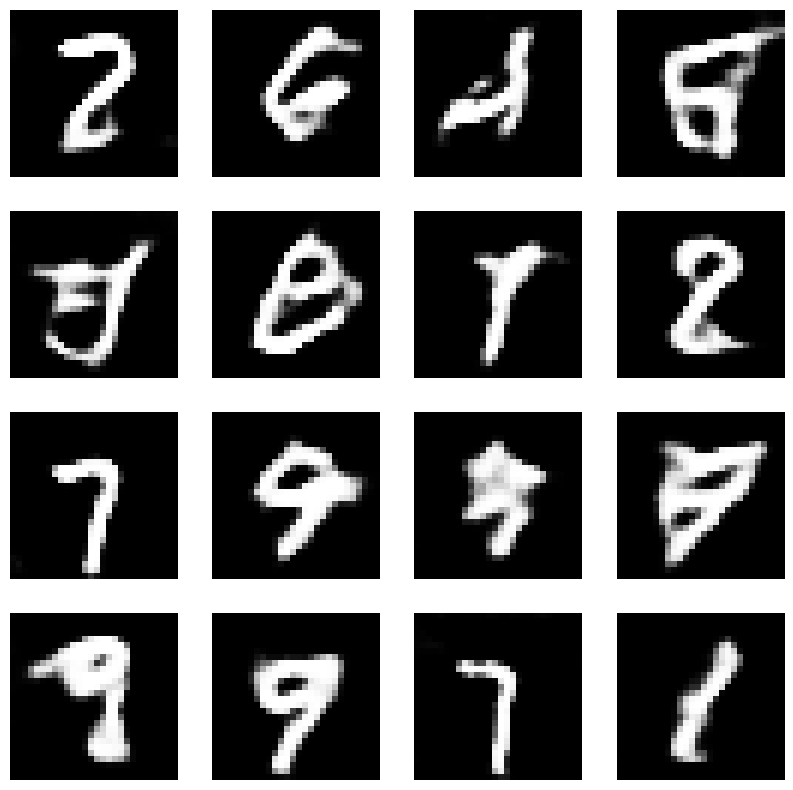

In [ ]:
test_images = tf.random.normal([number_of_images, noise_dimension])
train_gan(x_train, epochs, test_images)